In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
from scipy.stats import sem

parentDir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(os.path.join(os.getcwd(), "general_utils"))
# import file_management
from v1_model_utils import models, load_sparse, other_v1_utils
sys.path.append(os.path.join(os.getcwd(), "v1_model_utils"))
import analysis_utils as utils
from math import pi
from scipy import stats

import h5py
import pickle as pkl
from scipy.ndimage import gaussian_filter
from numba import njit

%load_ext line_profiler

# Set style parameters for publication quality
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'axes.linewidth': 1.2,
    'axes.labelpad': 8,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'legend.frameon': True,
    'legend.fontsize': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.transparent': True
})

sns.set(style="ticks")
plt.rcParams['text.usetex'] = True

/tmp/ipykernel_3103479/119553692.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2025-04-11 23:44:38.420094: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 23:44:38.459140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: S

## CSV FILES LOADING AND LGN DATA FOR OSI/DSI ANALYSIS

In [59]:
# cache_path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/GLIF_network/tf_data/V1_network_v1_65871.pkl'
cache_path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/GLIF_network/tf_data/V1_network_v1_65871_random_weights_True.pkl'
with open(cache_path, 'rb') as f:
    network, lgn_input, bkg_input = pkl.load(f)

# Extract main variables from the network
voltage_scale = (network['node_params']['V_th'] - network['node_params']['E_L']).astype(np.float32)
variable_key = f'sparse_recurrent_weights:0'
indices = network["synapses"]["indices"].astype(np.int32)
node_type_ids = network['node_type_ids']

# Load the V1 data csv
# v1_path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/Simulation_results/v1_65871/b_5abx/v1_features_df.csv'
v1_path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/Simulation_results/v1_65871_random_weights_True/b_py7q/v1_features_df.csv'
# v1_path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/Simulation_results/v1_65871/b_9135/Best_model/ckpt-98_results/v1_features_df.csv'
v1_core_df = pd.read_csv(v1_path, sep=' ')

# Load the checkpoint
# ckpt_path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/Simulation_results/v1_65871/b_9135/Best_model'
# ckpt_path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/Simulation_results/v1_65871/b_5abx/Best_model'
ckpt_path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/Simulation_results/v1_65871_random_weights_True/b_py7q/Best_model'
checkpoint_directory = tf.train.latest_checkpoint(ckpt_path)
print(f'Restoring checkpoint from {checkpoint_directory}...')

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
dtype = tf.float16

# Build the model
model = models.create_model(
            network,
            lgn_input,
            bkg_input,
            seq_len=500,
            n_input=17400,
            n_output=2,
            cue_duration=40,
            dtype=dtype,
            input_weight_scale=1.,
            dampening_factor=.5,
            recurrent_dampening_factor=0.5,
            gauss_std=.3,
            lr_scale=1.,
            train_input=False,
            train_noise=True,
            train_recurrent=True,
            train_recurrent_per_type=False,
            neuron_output=False,
            batch_size=1,
            pseudo_gauss=False,
            use_state_input=True,
            return_state=True,
            hard_reset=False,
            add_metric=True,
            max_delay=5,
        )

model.build((1, 1000, 17400))

# Store the initial model variables that are going to be trained
model_variables_dict = {'Initial': {var.name: var.numpy().astype(np.float32) for var in model.trainable_variables}}
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(checkpoint_directory).expect_partial()#.assert_consumed()
model_variables_dict['Restored'] = {var.name: var.numpy().astype(np.float32) for var in model.trainable_variables}

Restoring checkpoint from /home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/Simulation_results/v1_65871_random_weights_True/b_py7q/Best_model/ckpt-50...
Creating the V1 column...
    > # Recurrent synapses: 23525415
    > # LGN input synapses 30852826
    > # BKG input synapses 263484


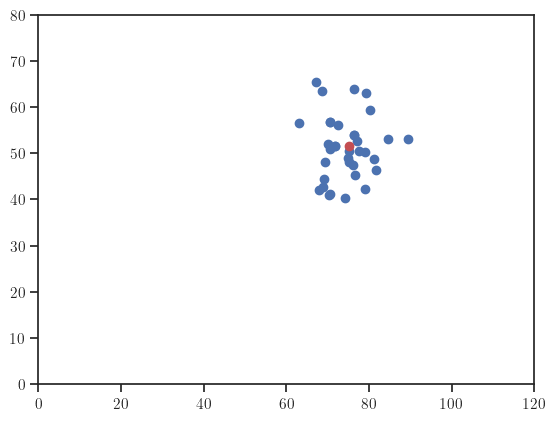

In [60]:
path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/GLIF_network/tf_data/lgn_full_col_cells_120x80.csv'
lgn_data = pd.read_csv(path, sep=' ')
v1_neuron_id = 0
# for v1_neuron_id in range(10):
mask = lgn_input['indices'][:, 0] == v1_neuron_id
lgn_ids = lgn_input['indices'][:, 1][mask]
x, y = lgn_data['x'][lgn_ids].values, lgn_data['y'][lgn_ids].values
plt.plot(x, y, 'o')
plt.plot(network['x'][v1_neuron_id] * 70/1000 + 60, network['z'][v1_neuron_id] * 40/1000 + 40, 'ro')
plt.xlim(0, 120)
plt.ylim(0, 80)
plt.show()

In [61]:
v1_pop_names = other_v1_utils.pop_names(network)
v1_cell_types = [other_v1_utils.pop_name_to_cell_type(pop_name) for pop_name in v1_pop_names]
v1_ei = [n[0] for n in v1_pop_names]
v1_core_mask = other_v1_utils.isolate_core_neurons(network, n_selected_neurons=16366, data_dir='GLIF_network')
v1_core_indices = np.where(v1_core_mask)[0]
v1_core_df['tf_id'] = v1_core_indices

all_v1_neurons_df = pd.DataFrame({
    'tf_id': np.arange(len(v1_pop_names)),
    'pop_name': v1_pop_names,
    'cell_type': v1_cell_types,
    'ei': v1_ei,
    'tuning_angle': network['tuning_angle'],
    'x': network['x'],
    'y': network['y'],
    'z': network['z'],
    'azimuth': network['x'] * 70/1000 + 60,
    'elevation': network['z'] * 40/1000 + 40
})

v1_df = pd.merge(all_v1_neurons_df, v1_core_df, on=['tf_id', 'pop_name'], how='outer')
v1_df['area'] = 'v1'
v1_df['region'] = np.where(v1_df['tf_id'].isin(v1_core_indices), 'core', 'annulus')

# can we set two indices: first the area and then the tf_id
v1_df.set_index(['area', 'tf_id'], inplace=True)
# df.set_index('tf_id', inplace=True)
v1_df.dropna(subset=['preferred_angle'], inplace=True)

df = v1_df.loc['v1']
df

pop_name cell_type ei  tuning_angle           x           y           z  \
tf_id                                                                           
11     i1Htr3a  L1 Htr3a  i     19.899498  -78.635796  -56.364803  -87.265877   
46     i1Htr3a  L1 Htr3a  i     83.216080   67.729317 -134.154648  -73.350883   
53     i1Htr3a  L1 Htr3a  i     95.879395  -67.371452  -52.680973 -165.397781   
54     i1Htr3a  L1 Htr3a  i     97.688438   68.592155 -154.241623  -59.886154   
61     i1Htr3a  L1 Htr3a  i    110.351761  113.091087  -59.271404  159.034592   
...        ...       ... ..           ...         ...         ...         ...   
65783    i6Sst    L6 SST  i    351.627899   90.949677 -668.467651  150.117447   
65784    i6Sst    L6 SST  i    355.813965  104.975182 -798.193420  129.191315   
65840    i6Sst    L6 SST  i    230.232559  -97.871368 -777.068604  156.239929   
65853    i6Sst    L6 SST  i    284.651154 -106.858345 -773.283020 -151.685425   
65869    i6Sst    L6 SST  i    351.627899 -170.762405 -686.952271   47.039146   

         azimuth  elevation  node_id  max_mean_rate(Hz)  preferred_angle  \
tf_id                                                                      
11     54.495495  36.509365      5.0           4.996197        14.231871   
46     64.741051  37.065964     14.0           6.988580        93.134977   
53     55.283997  33.384090     15.0           5.307502        93.852476   
54     64.801453  37.604553     16.0           2.320126        81.561225   
61     67.916374  46.361385     17.0           2.114884       142.196263   
...          ...        ...      ...                ...              ...   
65783  66.366478  46.004700  16344.0           4.009482       337.928307   
65784  67.348267  45.167652  16345.0           6.130906       268.955781   
65840  53.149006  46.249596  16359.0           7.189379       248.155744   
65853  52.519917  33.932583  16361.0           0.971165       260.705410   
65869  48.046631  41.881565  16364.0           0.257673       138.028327   

            OSI       DSI  Ave_Rate(Hz)  firing_rate_sp region  
tf_id                                                           
11     0.325238  0.415202       2.03125           0.450   core  
46     0.044685  0.017079       6.19375           7.350   core  
53     0.288325  0.312112       2.12500           0.775   core  
54     0.257018  0.247990       0.88750          13.325   core  
61     0.167112  0.082460       1.53750           1.075   core  
...         ...       ...           ...             ...    ...  
65783  0.053467  0.070005       4.16250           9.650   core  
65784  0.043880  0.035343       5.41250          11.400   core  
65840  0.415175  0.054865       2.84375           0.800   core  
65853  0.466317  0.506280       0.23750           8.250   core  
65869  0.591169  0.099442       0.10625           5.225   core  

[12815 rows x 17 columns]

In [62]:
# #take a sample of the df but keep it ordered
# df = df.sample(frac=0.1).sort_index()
# df

## FUNCTIONS TOOLKIT

In [63]:
@njit
def fast_indices_masking(indices, target_tf_ids, source_tf_ids):
    target_tf_ids_set = set(target_tf_ids)
    source_tf_ids_set = set(source_tf_ids)
    mask = np.zeros(indices.shape[0], dtype=np.bool_)
    for k in range(indices.shape[0]):
        i, j = indices[k]
        if i in target_tf_ids_set and j in source_tf_ids_set:
            mask[k] = True
    return mask

## PREFERRED VS TUNING ANGLE HISTOGRAM

V1 Percentage of responsive neurons: 100.0
V1 Mean difference between preferred and estimated tuning angle: 17.338938182950326


(<Figure size 1500x1200 with 1 Axes>,
 <Axes: xlabel='Labeled - Fitted Tuning Angle (°)', ylabel='Number of Neurons'>)

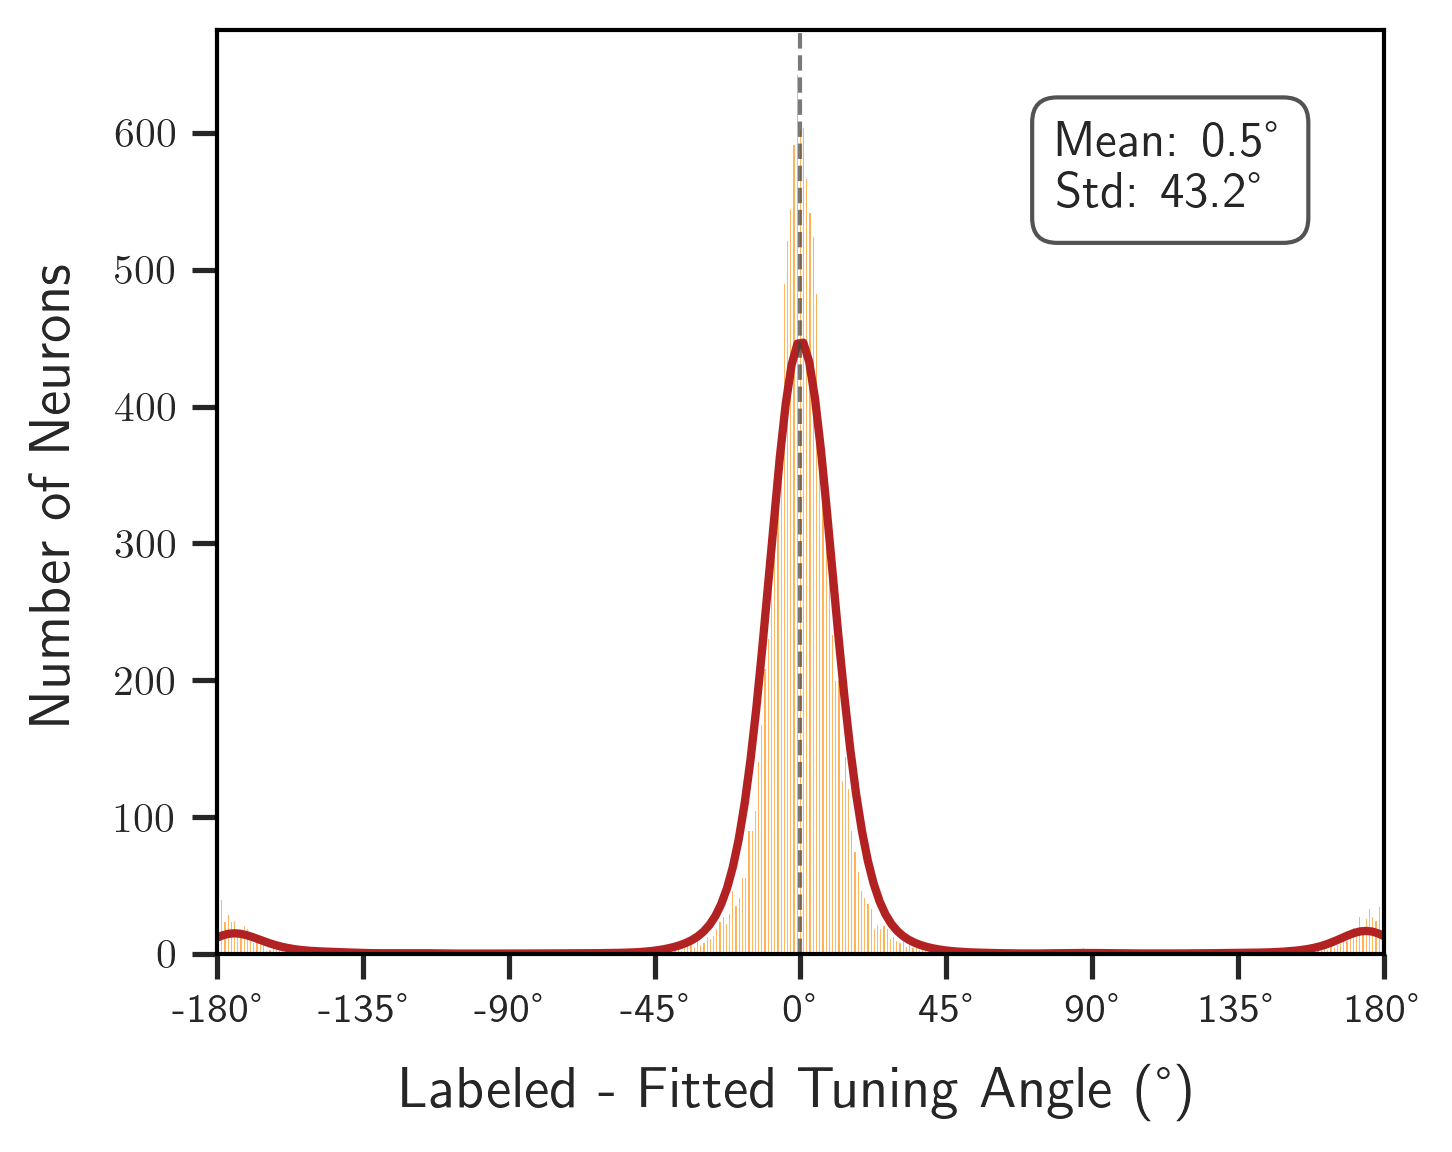

In [64]:
# plot an histogram with the variation of the tuning angle
v1_tuning_angles_diff = df['tuning_angle'] - df['preferred_angle']
v1_responsive_neurons_mask = np.logical_not(np.isnan(v1_tuning_angles_diff))
v1_tuning_angles_diff = v1_tuning_angles_diff[v1_responsive_neurons_mask]
v1_tuning_angles_diff = np.where(v1_tuning_angles_diff > 180, v1_tuning_angles_diff - 360, v1_tuning_angles_diff)
v1_tuning_angles_diff = np.where(v1_tuning_angles_diff < -180, v1_tuning_angles_diff + 360, v1_tuning_angles_diff)
print('V1 Percentage of responsive neurons:', np.sum(v1_responsive_neurons_mask) / len(v1_responsive_neurons_mask) * 100)
print('V1 Mean difference between preferred and estimated tuning angle:', np.nanmean(np.abs(v1_tuning_angles_diff)))

def plot_tuning_angle_variation(angle_diff, path='', save_fig=True):
    """
    Create a publication-ready plot showing the distribution of differences between 
    labeled and fitted tuning angles.
    
    Parameters:
    -----------
    angle_diff : numpy.ndarray
        Array of angle differences (labeled - fitted) in degrees
    path : str
        Directory path for saving the figure
    save_fig : bool
        Whether to save the figure or not
    """
    # Clean data - remove NaNs
    angle_diff = angle_diff[~np.isnan(angle_diff)]
    
    # Create figure with appropriate size and DPI for publication
    fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
    
    # Calculate optimal bin width using Freedman-Diaconis rule
    n_bins = utils.freedman_diaconis(angle_diff, returnas="bins")
    
    # Plot the histogram with KDE
    hist = sns.histplot(
        angle_diff, 
        bins=n_bins, 
        kde=True, 
        ax=ax, 
        color='#FF8C00',  # Darker orange for better visibility in print
        edgecolor='white',  # White edges for better bin definition
        linewidth=0.5,
        alpha=0.7, 
        stat='count'
    )
    
    # Get KDE line and make it more prominent
    line = hist.lines[0]
    line.set_color('#B22222')  # Darker red for KDE line
    line.set_linewidth(2)
    
    # Add vertical line at zero
    ax.axvline(x=0, color='#404040', linestyle='--', linewidth=1, alpha=0.7)
    
    # Add statistics box with mean and std
    mean_diff = np.mean(angle_diff)
    std_diff = np.std(angle_diff)
    median_diff = np.median(angle_diff)
    
    stats_text = (f'Mean: {mean_diff:.1f}°\n'
                 f'Std: {std_diff:.1f}°')
    
    # Create more elegant stats box
    box = dict(
        boxstyle='round,pad=0.5',
        facecolor='white', 
        edgecolor='#404040',
        alpha=0.9
    )
    
    ax.text(
        0.72, 0.9, 
        stats_text, 
        horizontalalignment='left', 
        verticalalignment='top', 
        transform=ax.transAxes, 
        fontsize=12,
        fontweight='medium',
        bbox=box
    )
    
    # Customize the appearance
    ax.set_xlim(-180, 180)
    # Set x-ticks every 45 degrees for more granularity
    xticks = np.arange(-180, 181, 45)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'{x}°' for x in xticks], fontsize=10)
    # Customize y-axis
    ax.tick_params(axis='y', labelsize=10)
    # Set labels with proper scientific formatting
    ax.set_xlabel('Labeled - Fitted Tuning Angle (°)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Neurons', fontsize=14, fontweight='bold')
    # Add a subtle title
    # ax.set_title('Distribution of Tuning Angle Differences', fontsize=11, pad=10)
    
    # Make borders more visible
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_color('black')
    
    # Tight layout with a bit more padding
    plt.tight_layout()
    
    # Save with high quality settings
    if save_fig:
        if not os.path.exists(path):
            os.makedirs(path, exist_ok=True)
        plt.savefig(
            os.path.join(path, 'V1_tuning_angle_variation.png'), 
            dpi=300, 
            bbox_inches='tight',
            transparent=True
        )
    
    return fig, ax

plot_tuning_angle_variation(v1_tuning_angles_diff, path='Paper_figures')

In [10]:
# plot an histogram with the variation of the tuning angle
v1_tuning_angles_diff = df['tuning_angle'] - df['preferred_angle']
v1_responsive_neurons_mask = np.logical_not(np.isnan(v1_tuning_angles_diff))
v1_tuning_angles_diff = v1_tuning_angles_diff[v1_responsive_neurons_mask]
v1_tuning_angles_diff = np.where(v1_tuning_angles_diff > 180, v1_tuning_angles_diff - 360, v1_tuning_angles_diff)
v1_tuning_angles_diff = np.where(v1_tuning_angles_diff < -180, v1_tuning_angles_diff + 360, v1_tuning_angles_diff)
print('V1 Percentage of responsive neurons:', np.sum(v1_responsive_neurons_mask) / len(v1_responsive_neurons_mask) * 100)
print('V1 Mean difference between preferred and estimated tuning angle:', np.nanmean(np.abs(v1_tuning_angles_diff)))
print('V1 STD difference between preferred and estimated tuning angle:', np.nanstd(np.abs(v1_tuning_angles_diff)))


V1 Percentage of responsive neurons: 100.0
V1 Mean difference between preferred and estimated tuning angle: 17.338938182950326
V1 STD difference between preferred and estimated tuning angle: 39.54892851580228


## WEIGHTS DISTRIBUTION IN TARGET NEURON COORDINATES

In [11]:
### DATA PREPARATION
cell_types = ['e', 'i']
source_cell_type = 'e'
target_cell_type = 'e'

# Select source and target IDs
source_tf_ids = df.index[df['ei'] == source_cell_type].astype(np.int32).values
target_tf_ids = df.index[(df['ei'] == target_cell_type) & (df['region'] == 'core')].astype(np.int32).values
# Create sets for fast lookup
mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
selected_indices = indices[mask]
target_indices = selected_indices[:, 0]
source_indices = selected_indices[:, 1]
# Mask voltage_scale_node_ids first
voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
initial_value_masked = model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids
final_value_masked = model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids
# Calculate tuning angle differences
target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
# Calculate differences in coordinates
source_azimuth = df.loc[source_indices, 'azimuth'].values
target_azimuth = df.loc[target_indices, 'azimuth'].values
source_elevation = df.loc[source_indices, 'elevation'].values
target_elevation = df.loc[target_indices, 'elevation'].values
# source position in the target centered coordinate system
diff_azimuth = source_azimuth - target_azimuth
diff_elevation = source_elevation - target_elevation
# get the target neuron angle to define the rotation
target_tuning_angle_rad = np.radians(target_tuning_angles)
cos_angles = np.cos(target_tuning_angle_rad)
sin_angles = np.sin(target_tuning_angle_rad)
# Rotate the sources coordinates according to the target neuron preferred direction
diff_x_rot = diff_azimuth * cos_angles + diff_elevation * sin_angles
diff_z_rot = diff_elevation * cos_angles - diff_azimuth * sin_angles

/tmp/ipykernel_170715/3257131702.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


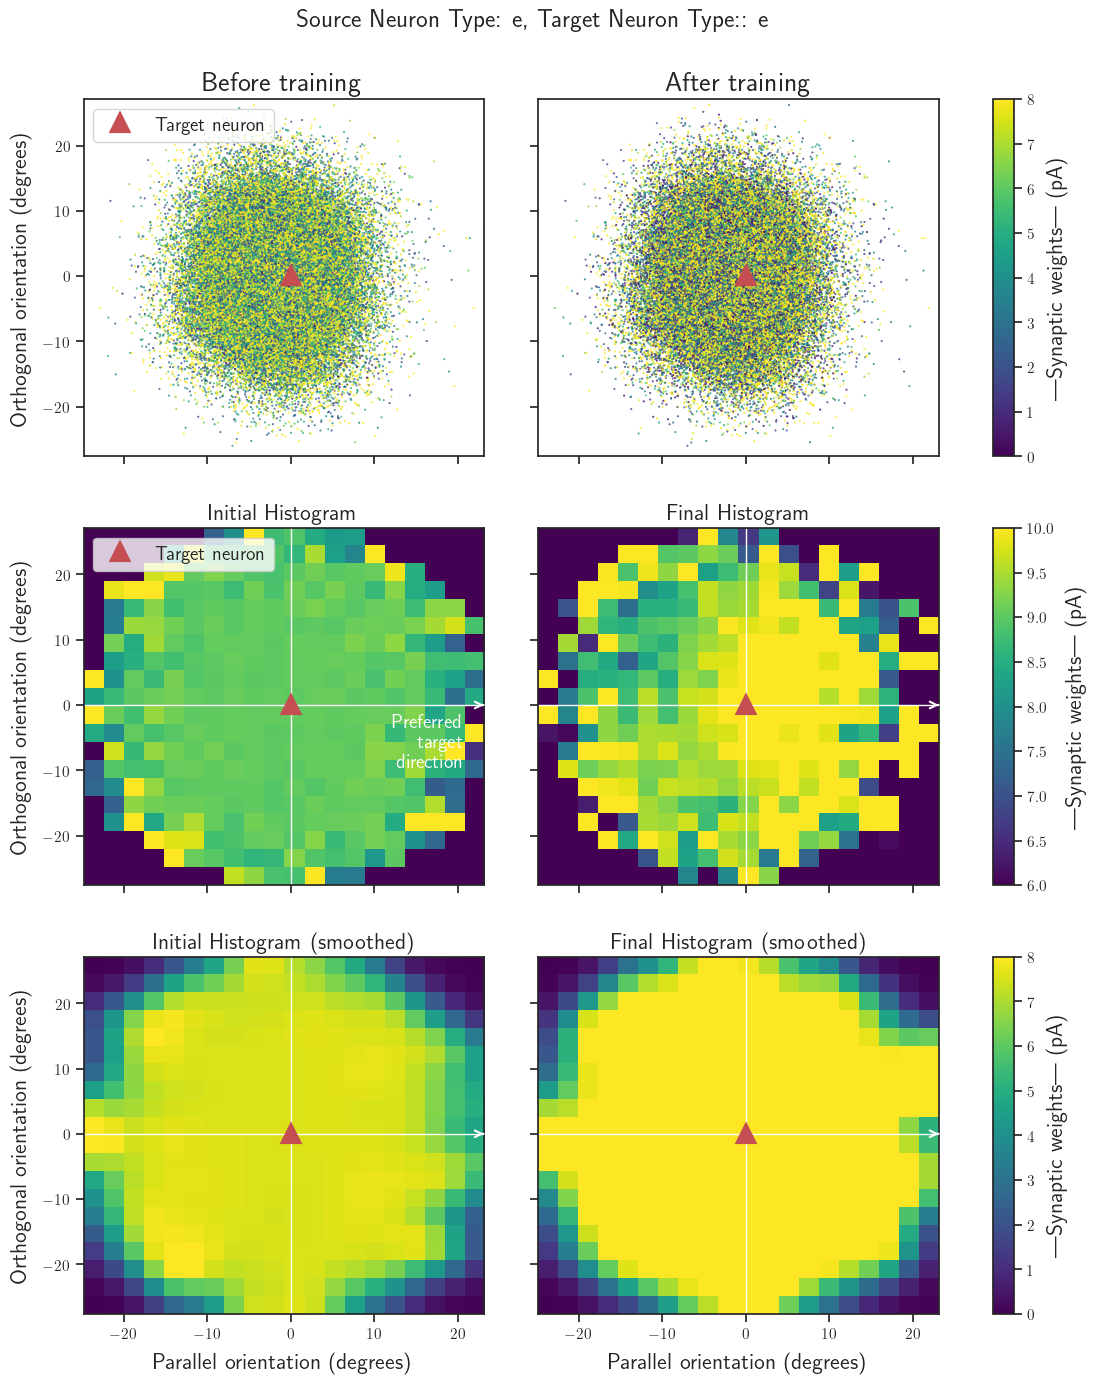

In [12]:
# Now represent the weights as a function of the difference in coordinates
fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 0.05], wspace=0.2, hspace=0.2)

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1], sharex=ax0, sharey=ax0)
# Randomly select indices to sample
n_samples = 100000
random_indices = np.random.choice(len(diff_x_rot), n_samples, replace=False)
# Initial scatter plot
scatter_initial = ax0.scatter(diff_x_rot[random_indices], diff_z_rot[random_indices], c=initial_value_masked[random_indices], 
                              cmap='viridis', s=0.2, alpha=1, vmin=0, vmax=8)
ax0.set_title('Before training', fontsize=20)
ax0.set_ylabel('Orthogonal orientation (degrees)', fontsize=16)
# Final scatter plot
scatter_final = ax1.scatter(diff_x_rot[random_indices], diff_z_rot[random_indices], c=final_value_masked[random_indices], 
                            cmap='viridis', s=0.2, alpha=1, vmin=0, vmax=8)
ax1.set_title('After training', fontsize=20)
scatter_cbar = plt.colorbar(scatter_final, cax=plt.subplot(gs[0, 2]))
scatter_cbar.set_label('|Synaptic weights| (pA)', fontsize=16)

# Create 2D histograms
bins = 20  # Number of bins in each dimension
# Initial histogram
H_initial, xedges_initial, yedges_initial = np.histogram2d(diff_x_rot, diff_z_rot, bins=bins, weights=initial_value_masked)
count_initial, _, _ = np.histogram2d(diff_x_rot, diff_z_rot, bins=bins)
H_initial = np.divide(H_initial, count_initial, out=np.zeros_like(H_initial), where=count_initial != 0)
# Final histogram
H_final, xedges_final, yedges_final = np.histogram2d(diff_x_rot, diff_z_rot, bins=bins, weights=final_value_masked)
count_final, _, _ = np.histogram2d(diff_x_rot, diff_z_rot, bins=bins)
H_final = np.divide(H_final, count_final, out=np.zeros_like(H_final), where=count_final != 0)

# Plot initial histogram with shared color scale
ax2 = plt.subplot(gs[1, 0], sharex=ax0, sharey=ax0)
im_initial = ax2.imshow(H_initial.T, origin='lower', 
                            extent=[xedges_initial[0], xedges_initial[-1], yedges_initial[0], yedges_initial[-1]], 
                            aspect='auto', cmap='viridis', vmin=0, vmax=10)
ax2.set_title('Initial Histogram', fontsize=16)
ax2.set_ylabel('Orthogonal orientation (degrees)', fontsize=16)
# Plot final histogram with shared color scale
ax3 = plt.subplot(gs[1, 1], sharex=ax0, sharey=ax0)
im_final = ax3.imshow(H_final.T, origin='lower', 
                        extent=[xedges_final[0], xedges_final[-1], yedges_final[0], yedges_final[-1]], 
                        aspect='auto', cmap='viridis', vmin=6, vmax=10)
ax3.set_title('Final Histogram', fontsize=16)
cb_final = plt.colorbar(im_final, cax=plt.subplot(gs[1, 2]))
cb_final.set_label('|Synaptic weights| (pA)', fontsize=16)

# Apply Gaussian filter to histograms
sigma = 1  # Standard deviation for Gaussian kernel
H_initial_filtered = gaussian_filter(H_initial, sigma=sigma)
H_final_filtered = gaussian_filter(H_final, sigma=sigma)
# Plot initial histogram with Gaussian filter applied
ax4 = plt.subplot(gs[2, 0], sharex=ax0, sharey=ax0)
im_initial_filtered = ax4.imshow(H_initial_filtered.T, origin='lower', 
                                    extent=[xedges_initial[0], xedges_initial[-1], yedges_initial[0], yedges_initial[-1]], 
                                    aspect='auto', cmap='viridis', vmin=0, vmax=8) 
ax4.set_title('Initial Histogram (smoothed)', fontsize=16)
ax4.set_xlabel('Parallel orientation (degrees)', fontsize=16)
ax4.set_ylabel('Orthogonal orientation (degrees)', fontsize=16)
# Plot final histogram with Gaussian filter applied
ax5 = plt.subplot(gs[2, 1], sharex=ax0, sharey=ax0)
im_final_filtered = ax5.imshow(H_final_filtered.T, origin='lower', 
                                    extent=[xedges_final[0], xedges_final[-1], yedges_final[0], yedges_final[-1]], 
                                    aspect='auto', cmap='viridis', vmin=0, vmax=8)
ax5.set_title('Final Histogram (smoothed)', fontsize=16)
ax5.set_xlabel('Parallel orientation (degrees)', fontsize=16)
cb_final_filtered = plt.colorbar(im_final_filtered, cax=plt.subplot(gs[2, 2]))
cb_final_filtered.set_label(r'|Synaptic weights| (pA)', fontsize=16)
# Draw arrow and text for each subplot at y=0
for ax in [ax2, ax3, ax4, ax5]:
    ax.axvline(0, color='white', lw=1)
    ax.axhline(0, color='white', lw=1)
    ax.annotate('', xy=(ax.get_xlim()[1], 0), xytext=(ax.get_xlim()[1]-0.1, 0),
                arrowprops=dict(arrowstyle='->', color='white', lw=1.5))
    if ax == ax2:
        # Position for the centered text at the right end of the x-axis
        x_right = x_right = ax.get_xlim()[1] - 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # Move left by 10% of x-axis range
        y_position = -0.025 * (ax.get_ylim()[1] - ax.get_ylim()[0])
        ax.text(x_right, y_position,
                'Preferred \n target \n direction', color='white', ha='right', va='top', fontsize=14, weight='bold')
# Hide y ticks for specific subplots (e.g., ax1, ax3, ax5)
for ax in [ax1, ax3, ax5]:
    ax.tick_params(axis='y', labelleft=False)
# Hide x ticks for specific subplots (e.g., ax0, ax1, ax2, ax3)
for ax in [ax0, ax1, ax2, ax3]:
    ax.tick_params(axis='x', labelbottom=False)

for ax in [ax0, ax1, ax2, ax3, ax4, ax5]:
    ax.plot(0, 0, 'r^', markersize=12, markeredgewidth=3, label='Target neuron')
ax0.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper left', fontsize=14)

fig.suptitle(f'Source Neuron Type: {source_cell_type}, Target Neuron Type:: {target_cell_type}', fontsize=18)
fig.subplots_adjust(top=0.92)
plt.tight_layout()
plt.show()

## WEIGHTS DISTRIBUTION FOR PARALLEL, PERPENDICULAR AND OPPOSITTE SOURCE NEURONS


e - e : Mean value of parallel histogram: 7.665306568145752
e - e : Mean value of perpendicular histogram: 7.545932769775391
e - e : Mean value of opposite histogram: 7.561152458190918

e - i : Mean value of parallel histogram: 15.61391544342041
e - i : Mean value of perpendicular histogram: 15.59381103515625
e - i : Mean value of opposite histogram: 15.424571990966797

i - e : Mean value of parallel histogram: 9.40206527709961
i - e : Mean value of perpendicular histogram: 9.499092102050781
i - e : Mean value of opposite histogram: 9.3192720413208

i - i : Mean value of parallel histogram: 7.038084030151367
i - i : Mean value of perpendicular histogram: 7.230981349945068
i - i : Mean value of opposite histogram: 7.219483375549316


/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


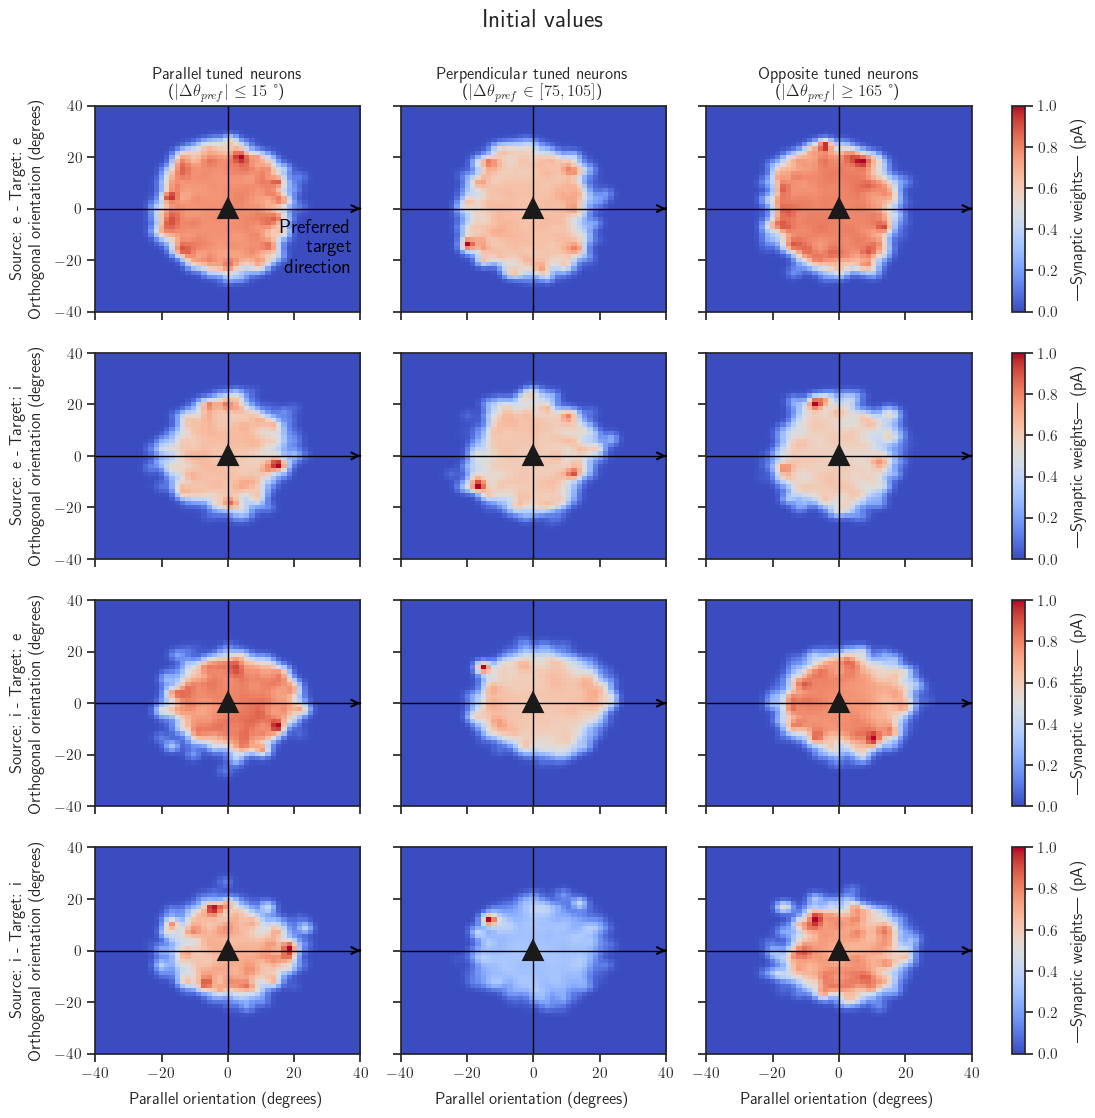

In [13]:
target_cell_types = ['e', 'i']
source_cell_types = ['e', 'i']

fig = plt.figure(figsize=(12, 6 * len(source_cell_types)), constrained_layout=True)
if len(source_cell_types) * len(target_cell_types) == 4:
    top_title_space = 0.9
else:
    top_title_space = 0.85
gs = gridspec.GridSpec(len(source_cell_types) * len(target_cell_types), 4, width_ratios=[1, 1, 1, 0.05], top=top_title_space, wspace=0.2, hspace=0.2)
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    # Select source and target IDs
    # source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core') & (df['OSI'] > 0.2)].astype(np.int32).values
    source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core')].astype(np.int32).values
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = df.index[(df['ei'] == target_cell_type) & (df['region'] == 'core')].astype(np.int32).values
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = np.abs(model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids)
        final_value_masked = np.abs(model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids)
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
        target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)
        # Calculate differences in coordinates
        source_azimuth = df.loc[source_indices, 'azimuth'].values
        target_azimuth = df.loc[target_indices, 'azimuth'].values
        source_elevation = df.loc[source_indices, 'elevation'].values
        target_elevation = df.loc[target_indices, 'elevation'].values
        # source position in the target centered coordinate system
        diff_azimuth = source_azimuth - target_azimuth
        diff_elevation = source_elevation - target_elevation
        # get the target neuron angle to define the rotation
        target_tuning_angle_rad = np.radians(target_tuning_angles)
        cos_angles = np.cos(target_tuning_angle_rad)
        sin_angles = np.sin(target_tuning_angle_rad)
        # Rotate the sources coordinates according to the target neuron preferred direction
        diff_x_rot = diff_azimuth * cos_angles + diff_elevation * sin_angles
        diff_z_rot = diff_elevation * cos_angles - diff_azimuth * sin_angles
        # Distinghish between parallel, orthogonal and opposite tuning angles
        # Parallel
        parallel_tuning_mask = tuning_angle_diff < 15
        parallel_diff_x = diff_x_rot[parallel_tuning_mask]
        parallel_diff_z = diff_z_rot[parallel_tuning_mask]
        parallel_final_value_masked = initial_value_masked[parallel_tuning_mask]

        # Orthogonal
        orthogonal_tuning_mask = np.logical_and(tuning_angle_diff > 80, tuning_angle_diff < 100)
        orthogonal_diff_x = diff_x_rot[orthogonal_tuning_mask]
        orthogonal_diff_z = diff_z_rot[orthogonal_tuning_mask]
        orthogonal_final_value_masked = initial_value_masked[orthogonal_tuning_mask]
        # Opposite
        opposite_tuning_mask = tuning_angle_diff > 165
        opposite_diff_x = diff_x_rot[opposite_tuning_mask]
        opposite_diff_z = diff_z_rot[opposite_tuning_mask]
        opposite_final_value_masked = initial_value_masked[opposite_tuning_mask]

        bins = 50
        area_dimensions = [[-40, 40], [-40, 40]]
        # area_dimensions = [[-10, 10], [-10, 10]]
        # Parallel
        H_parallel, xedges_parallel, yedges_parallel = np.histogram2d(parallel_diff_x, parallel_diff_z, bins=bins, range=area_dimensions, weights=parallel_final_value_masked)
        count_parallel, _, _ = np.histogram2d(parallel_diff_x, parallel_diff_z, range=area_dimensions, bins=bins)
        H_parallel = np.divide(H_parallel, count_parallel, out=np.zeros_like(H_parallel), where=count_parallel != 0)
        # Orthogonal
        H_perpendicular, xedges_perpendicular, yedges_perpendicular = np.histogram2d(orthogonal_diff_x, orthogonal_diff_z, bins=bins, range=area_dimensions, weights=orthogonal_final_value_masked)
        count_perpendicular, _, _ = np.histogram2d(orthogonal_diff_x, orthogonal_diff_z, range=area_dimensions, bins=bins)
        H_perpendicular = np.divide(H_perpendicular, count_perpendicular, out=np.zeros_like(H_perpendicular), where=count_perpendicular != 0)
        # Opposite
        H_opp, xedges_opp, yedges_opp = np.histogram2d(opposite_diff_x, opposite_diff_z, bins=bins, range=area_dimensions, weights=opposite_final_value_masked)
        count_opp, _, _ = np.histogram2d(opposite_diff_x, opposite_diff_z, range=area_dimensions, bins=bins)
        H_opp = np.divide(H_opp, count_opp, out=np.zeros_like(H_opp), where=count_opp != 0)
        # Apply Gaussian filter to histograms
        sigma = 1
        H_parallel_filtered = gaussian_filter(H_parallel, sigma=sigma)
        H_perpendicular_filtered = gaussian_filter(H_perpendicular, sigma=sigma)
        H_opp_filtered = gaussian_filter(H_opp, sigma=sigma)
        # Normalize them with respect to the maximum value
        H_parallel_filtered = H_parallel_filtered / np.max(H_parallel_filtered)
        H_perpendicular_filtered = H_perpendicular_filtered / np.max(H_perpendicular_filtered)
        H_opp_filtered = H_opp_filtered / np.max(H_opp_filtered)
        
        # print the mean values of each histogram
        print()
        print(f'{source_cell_type} - {target_cell_type} : Mean value of parallel histogram: {np.mean(parallel_final_value_masked)}')
        print(f'{source_cell_type} - {target_cell_type} : Mean value of perpendicular histogram: {np.mean(orthogonal_final_value_masked)}')
        print(f'{source_cell_type} - {target_cell_type} : Mean value of opposite histogram: {np.mean(opposite_final_value_masked)}')
        # Define limits of the histograms
        # global_min = 0
        # global_max = 30
        # Get the access for each subplot
        ax_parallel = plt.subplot(gs[plot_index, 0])
        ax_perpendicular = plt.subplot(gs[plot_index, 1], sharex=ax_parallel, sharey=ax_parallel)
        ax_opposite = plt.subplot(gs[plot_index, 2], sharex=ax_parallel, sharey=ax_parallel)

        im_parallel_filtered = ax_parallel.imshow(H_parallel_filtered.T, origin='lower', 
                                                extent=[xedges_parallel[0], xedges_parallel[-1], yedges_parallel[0], yedges_parallel[-1]], 
                                                aspect='auto', cmap='coolwarm') #, vmin=global_min, vmax=global_max)
        ax_parallel.axhline(0, color='black', lw=1)
        ax_parallel.axvline(0, color='black', lw=1)
        ax_parallel.annotate('', xy=(ax_parallel.get_xlim()[1], 0), xytext=(ax_parallel.get_xlim()[1]-0.1, 0),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
        ax_parallel.set_ylabel(f'Source: {source_cell_type} - Target: {target_cell_type}\n Orthogonal orientation (degrees)', fontsize=12)

        im_perpendicular_filtered = ax_perpendicular.imshow(H_perpendicular_filtered.T, origin='lower', 
                                                            extent=[xedges_perpendicular[0], xedges_perpendicular[-1], yedges_perpendicular[0], yedges_perpendicular[-1]], 
                                                            aspect='auto', cmap='coolwarm') #, vmin=global_min, vmax=global_max)
        ax_perpendicular.axhline(0, color='black', lw=1)
        ax_perpendicular.axvline(0, color='black', lw=1)
        ax_perpendicular.annotate('', xy=(ax_perpendicular.get_xlim()[1], 0), xytext=(ax_perpendicular.get_xlim()[1]-0.1, 0),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
        
        im_opp_filtered = ax_opposite.imshow(H_opp_filtered.T, origin='lower', 
                                            extent=[xedges_opp[0], xedges_opp[-1], yedges_opp[0], yedges_opp[-1]], 
                                            aspect='auto', cmap='coolwarm') #, vmin=global_min, vmax=global_max)
        ax_opposite.axhline(0, color='black', lw=1)
        ax_opposite.axvline(0, color='black', lw=1)
        ax_opposite.annotate('', xy=(ax_opposite.get_xlim()[1], 0), xytext=(ax_opposite.get_xlim()[1]-0.1, 0),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

        cbar = plt.colorbar(im_opp_filtered, cax=plt.subplot(gs[plot_index, 3]))
        cbar.set_label('|Synaptic weights| (pA)')

        ax_parallel.plot(0, 0, 'k^', markersize=12, markeredgewidth=3, label='Target neuron')
        ax_perpendicular.plot(0, 0, 'k^', markersize=12, markeredgewidth=3, label='Target neuron')
        ax_opposite.plot(0, 0, 'k^', markersize=12, markeredgewidth=3, label='Target neuron')

        if row == 0 and col == 0:
            ax_parallel.set_title(f'Parallel tuned neurons\n' + r'($|\Delta \theta_{pref}| \leq 15$ °)')
            ax_perpendicular.set_title(f'Perpendicular tuned neurons\n' + r'($|\Delta \theta_{pref} \in [75, 105]$)')
            ax_opposite.set_title(f'Opposite tuned neurons\n' + r'($|\Delta \theta_{pref}| \geq 165$ °)')
            # Position for the centered text at the right end of the x-axis
            x_right = ax_parallel.get_xlim()[1] - 0.03 * (ax_parallel.get_xlim()[1] - ax_parallel.get_xlim()[0])  # Move left by 10% of x-axis range
            y_position = -0.05 * (ax_parallel.get_ylim()[1] - ax_parallel.get_ylim()[0])
            ax_parallel.text(x_right, y_position,
                    'Preferred \n target\n direction', color='black', ha='right', va='top', fontsize=14, weight='bold')
            
        plt.setp(ax_perpendicular.get_yticklabels(), visible=False)
        plt.setp(ax_opposite.get_yticklabels(), visible=False)
        plot_index += 1

for i in range(plot_index-1):
    plt.setp(plt.subplot(gs[i, 0]).get_xticklabels(), visible=False)
    plt.setp(plt.subplot(gs[i, 1]).get_xticklabels(), visible=False)
    plt.setp(plt.subplot(gs[i, 2]).get_xticklabels(), visible=False)

plt.subplot(gs[plot_index-1, 0]).set_xlabel('Parallel orientation (degrees)')
plt.subplot(gs[plot_index-1, 1]).set_xlabel('Parallel orientation (degrees)')
plt.subplot(gs[plot_index-1, 2]).set_xlabel('Parallel orientation (degrees)')

fig.suptitle(f'Initial values', fontsize=18)
plt.show()


e - e : Mean value of parallel histogram: 17.760231018066406
e - e : Mean value of perpendicular histogram: 6.029980182647705
e - e : Mean value of opposite histogram: 10.603301048278809

e - i : Mean value of parallel histogram: 15.119863510131836
e - i : Mean value of perpendicular histogram: 10.27087688446045
e - i : Mean value of opposite histogram: 12.448286056518555

i - e : Mean value of parallel histogram: 6.807430267333984
i - e : Mean value of perpendicular histogram: 9.475655555725098
i - e : Mean value of opposite histogram: 6.801470756530762

i - i : Mean value of parallel histogram: 8.564939498901367
i - i : Mean value of perpendicular histogram: 9.62065601348877
i - i : Mean value of opposite histogram: 8.39941692352295


/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


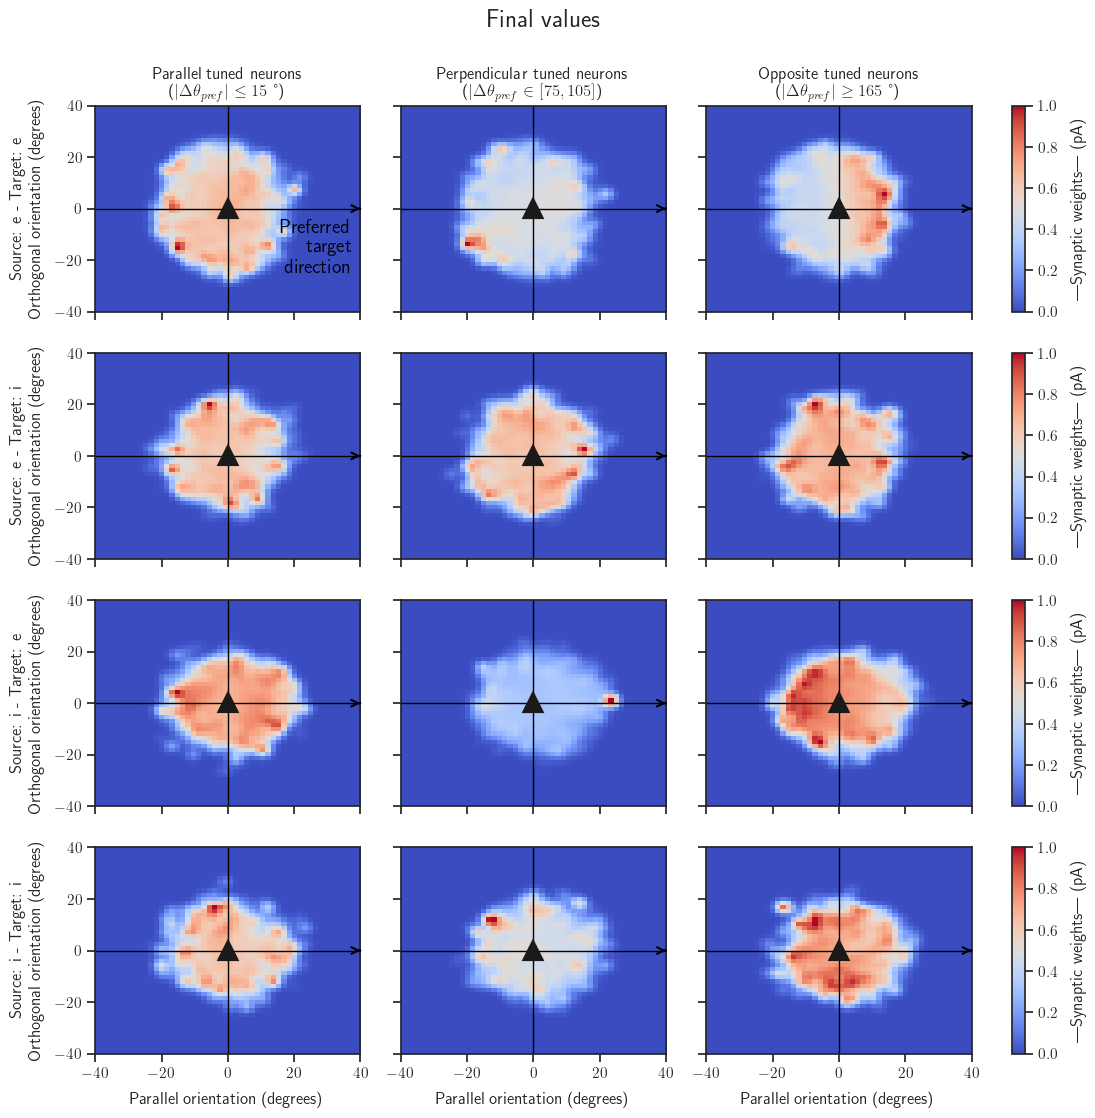

In [14]:
target_cell_types = ['e', 'i']
source_cell_types = ['e', 'i']

fig = plt.figure(figsize=(12, 6 * len(source_cell_types)), constrained_layout=True)
if len(source_cell_types) * len(target_cell_types) == 4:
    top_title_space = 0.9
else:
    top_title_space = 0.85
gs = gridspec.GridSpec(len(source_cell_types) * len(target_cell_types), 4, width_ratios=[1, 1, 1, 0.05], top=top_title_space, wspace=0.2, hspace=0.2)
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    # Select source and target IDs
    # source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core') & (df['OSI'] > 0.2)].astype(np.int32).values
    source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core')].astype(np.int32).values
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = df.index[(df['ei'] == target_cell_type) & (df['region'] == 'core')].astype(np.int32).values
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = np.abs(model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids)
        final_value_masked = np.abs(model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids)
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
        target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)
        # Calculate differences in coordinates
        source_azimuth = df.loc[source_indices, 'azimuth'].values
        target_azimuth = df.loc[target_indices, 'azimuth'].values
        source_elevation = df.loc[source_indices, 'elevation'].values
        target_elevation = df.loc[target_indices, 'elevation'].values
        # source position in the target centered coordinate system
        diff_azimuth = source_azimuth - target_azimuth
        diff_elevation = source_elevation - target_elevation
        # get the target neuron angle to define the rotation
        target_tuning_angle_rad = np.radians(target_tuning_angles)
        cos_angles = np.cos(target_tuning_angle_rad)
        sin_angles = np.sin(target_tuning_angle_rad)
        # Rotate the sources coordinates according to the target neuron preferred direction
        diff_x_rot = diff_azimuth * cos_angles + diff_elevation * sin_angles
        diff_z_rot = diff_elevation * cos_angles - diff_azimuth * sin_angles
        # Distinghish between parallel, orthogonal and opposite tuning angles
        # Parallel
        parallel_tuning_mask = tuning_angle_diff < 15
        parallel_diff_x = diff_x_rot[parallel_tuning_mask]
        parallel_diff_z = diff_z_rot[parallel_tuning_mask]
        parallel_final_value_masked = final_value_masked[parallel_tuning_mask]
        # parallel_final_value_masked = initial_value_masked[parallel_tuning_mask]

        # Orthogonal
        orthogonal_tuning_mask = np.logical_and(tuning_angle_diff > 80, tuning_angle_diff < 100)
        orthogonal_diff_x = diff_x_rot[orthogonal_tuning_mask]
        orthogonal_diff_z = diff_z_rot[orthogonal_tuning_mask]
        orthogonal_final_value_masked = final_value_masked[orthogonal_tuning_mask]
        # orthogonal_final_value_masked = initial_value_masked[orthogonal_tuning_mask]
        # Opposite
        opposite_tuning_mask = tuning_angle_diff > 165
        opposite_diff_x = diff_x_rot[opposite_tuning_mask]
        opposite_diff_z = diff_z_rot[opposite_tuning_mask]
        opposite_final_value_masked = final_value_masked[opposite_tuning_mask]
        # opposite_final_value_masked = initial_value_masked[opposite_tuning_mask]

        bins = 50
        area_dimensions = [[-40, 40], [-40, 40]]
        # area_dimensions = [[-10, 10], [-10, 10]]
        # Parallel
        H_parallel, xedges_parallel, yedges_parallel = np.histogram2d(parallel_diff_x, parallel_diff_z, bins=bins, range=area_dimensions, weights=parallel_final_value_masked)
        count_parallel, _, _ = np.histogram2d(parallel_diff_x, parallel_diff_z, range=area_dimensions, bins=bins)
        H_parallel = np.divide(H_parallel, count_parallel, out=np.zeros_like(H_parallel), where=count_parallel != 0)
        # Orthogonal
        H_perpendicular, xedges_perpendicular, yedges_perpendicular = np.histogram2d(orthogonal_diff_x, orthogonal_diff_z, bins=bins, range=area_dimensions, weights=orthogonal_final_value_masked)
        count_perpendicular, _, _ = np.histogram2d(orthogonal_diff_x, orthogonal_diff_z, range=area_dimensions, bins=bins)
        H_perpendicular = np.divide(H_perpendicular, count_perpendicular, out=np.zeros_like(H_perpendicular), where=count_perpendicular != 0)
        # Opposite
        H_opp, xedges_opp, yedges_opp = np.histogram2d(opposite_diff_x, opposite_diff_z, bins=bins, range=area_dimensions, weights=opposite_final_value_masked)
        count_opp, _, _ = np.histogram2d(opposite_diff_x, opposite_diff_z, range=area_dimensions, bins=bins)
        H_opp = np.divide(H_opp, count_opp, out=np.zeros_like(H_opp), where=count_opp != 0)
        # Apply Gaussian filter to histograms
        sigma = 1
        H_parallel_filtered = gaussian_filter(H_parallel, sigma=sigma)
        H_perpendicular_filtered = gaussian_filter(H_perpendicular, sigma=sigma)
        H_opp_filtered = gaussian_filter(H_opp, sigma=sigma)
        # Normalize them with respect to the maximum value
        H_parallel_filtered = H_parallel_filtered / np.max(H_parallel_filtered)
        H_perpendicular_filtered = H_perpendicular_filtered / np.max(H_perpendicular_filtered)
        H_opp_filtered = H_opp_filtered / np.max(H_opp_filtered)
        # print the mean values of each histogram
        print()
        print(f'{source_cell_type} - {target_cell_type} : Mean value of parallel histogram: {np.mean(parallel_final_value_masked)}')
        print(f'{source_cell_type} - {target_cell_type} : Mean value of perpendicular histogram: {np.mean(orthogonal_final_value_masked)}')
        print(f'{source_cell_type} - {target_cell_type} : Mean value of opposite histogram: {np.mean(opposite_final_value_masked)}')
        # Define limits of the histograms
        # global_min = 0
        # global_max = 30
        # Get the access for each subplot
        ax_parallel = plt.subplot(gs[plot_index, 0])
        ax_perpendicular = plt.subplot(gs[plot_index, 1], sharex=ax_parallel, sharey=ax_parallel)
        ax_opposite = plt.subplot(gs[plot_index, 2], sharex=ax_parallel, sharey=ax_parallel)

        im_parallel_filtered = ax_parallel.imshow(H_parallel_filtered.T, origin='lower', 
                                                extent=[xedges_parallel[0], xedges_parallel[-1], yedges_parallel[0], yedges_parallel[-1]], 
                                                aspect='auto', cmap='coolwarm') #, vmin=global_min, vmax=global_max)
        ax_parallel.axhline(0, color='black', lw=1)
        ax_parallel.axvline(0, color='black', lw=1)
        ax_parallel.annotate('', xy=(ax_parallel.get_xlim()[1], 0), xytext=(ax_parallel.get_xlim()[1]-0.1, 0),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
        ax_parallel.set_ylabel(f'Source: {source_cell_type} - Target: {target_cell_type}\n Orthogonal orientation (degrees)', fontsize=12)

        im_perpendicular_filtered = ax_perpendicular.imshow(H_perpendicular_filtered.T, origin='lower', 
                                                            extent=[xedges_perpendicular[0], xedges_perpendicular[-1], yedges_perpendicular[0], yedges_perpendicular[-1]], 
                                                            aspect='auto', cmap='coolwarm') #, vmin=global_min, vmax=global_max)
        ax_perpendicular.axhline(0, color='black', lw=1)
        ax_perpendicular.axvline(0, color='black', lw=1)
        ax_perpendicular.annotate('', xy=(ax_perpendicular.get_xlim()[1], 0), xytext=(ax_perpendicular.get_xlim()[1]-0.1, 0),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
        
        im_opp_filtered = ax_opposite.imshow(H_opp_filtered.T, origin='lower', 
                                            extent=[xedges_opp[0], xedges_opp[-1], yedges_opp[0], yedges_opp[-1]], 
                                            aspect='auto', cmap='coolwarm') #, vmin=global_min, vmax=global_max)
        ax_opposite.axhline(0, color='black', lw=1)
        ax_opposite.axvline(0, color='black', lw=1)
        ax_opposite.annotate('', xy=(ax_opposite.get_xlim()[1], 0), xytext=(ax_opposite.get_xlim()[1]-0.1, 0),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

        cbar = plt.colorbar(im_opp_filtered, cax=plt.subplot(gs[plot_index, 3]))
        cbar.set_label('|Synaptic weights| (pA)')

        ax_parallel.plot(0, 0, 'k^', markersize=12, markeredgewidth=3, label='Target neuron')
        ax_perpendicular.plot(0, 0, 'k^', markersize=12, markeredgewidth=3, label='Target neuron')
        ax_opposite.plot(0, 0, 'k^', markersize=12, markeredgewidth=3, label='Target neuron')

        if row == 0 and col == 0:
            ax_parallel.set_title(f'Parallel tuned neurons\n' + r'($|\Delta \theta_{pref}| \leq 15$ °)')
            ax_perpendicular.set_title(f'Perpendicular tuned neurons\n' + r'($|\Delta \theta_{pref} \in [75, 105]$)')
            ax_opposite.set_title(f'Opposite tuned neurons\n' + r'($|\Delta \theta_{pref}| \geq 165$ °)')
            # Position for the centered text at the right end of the x-axis
            x_right = ax_parallel.get_xlim()[1] - 0.03 * (ax_parallel.get_xlim()[1] - ax_parallel.get_xlim()[0])  # Move left by 10% of x-axis range
            y_position = -0.05 * (ax_parallel.get_ylim()[1] - ax_parallel.get_ylim()[0])
            ax_parallel.text(x_right, y_position,
                    'Preferred \n target\n direction', color='black', ha='right', va='top', fontsize=14, weight='bold')
            
        plt.setp(ax_perpendicular.get_yticklabels(), visible=False)
        plt.setp(ax_opposite.get_yticklabels(), visible=False)
        plot_index += 1

for i in range(plot_index-1):
    plt.setp(plt.subplot(gs[i, 0]).get_xticklabels(), visible=False)
    plt.setp(plt.subplot(gs[i, 1]).get_xticklabels(), visible=False)
    plt.setp(plt.subplot(gs[i, 2]).get_xticklabels(), visible=False)

plt.subplot(gs[plot_index-1, 0]).set_xlabel('Parallel orientation (degrees)')
plt.subplot(gs[plot_index-1, 1]).set_xlabel('Parallel orientation (degrees)')
plt.subplot(gs[plot_index-1, 2]).set_xlabel('Parallel orientation (degrees)')

fig.suptitle(f'Final values', fontsize=18)
plt.show()

## HIGH OSI/DSI SOURCES SPREAD

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


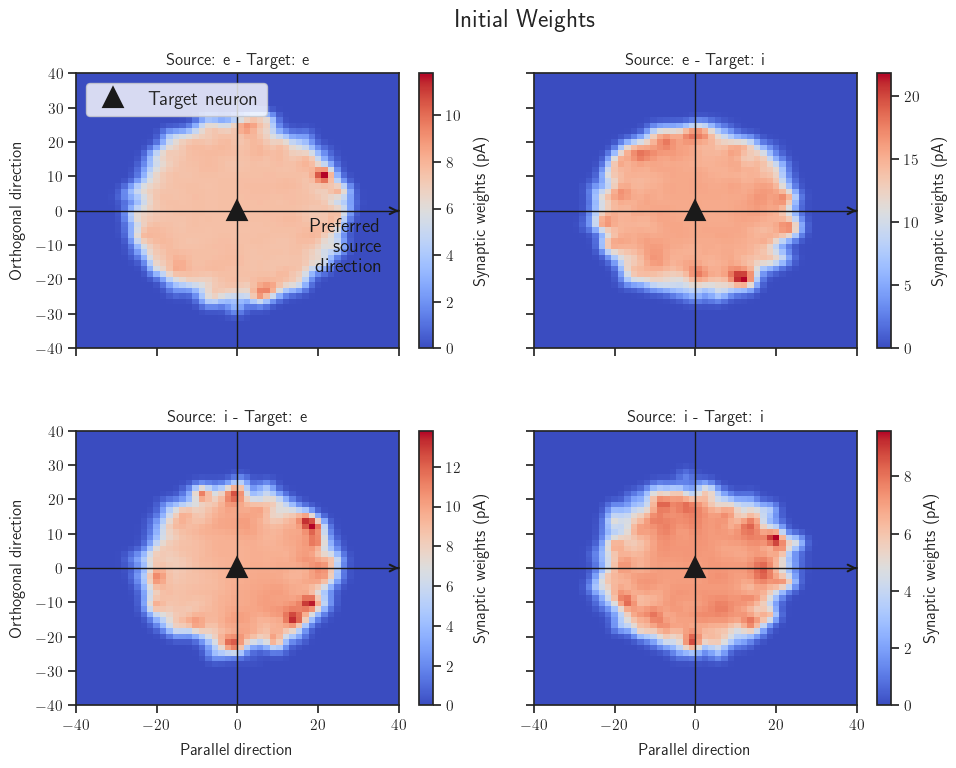

In [15]:
target_cell_types = ['e', 'i']
# target_cell_types = ['e5']
source_cell_types = ['e', 'i']
source_feature = 'DSI' # 'OSI'

fig = plt.figure(figsize=(6 * len(target_cell_types), 4 * len(source_cell_types)), constrained_layout=True)
if len(source_cell_types) * len(target_cell_types) == 4:
    top_title_space = 0.9
else:
    top_title_space = 0.8
gs = gridspec.GridSpec(len(source_cell_types), len(target_cell_types) + 1, width_ratios=[1, 1, 0.035], 
                        wspace=0.2, hspace=0.3, top=top_title_space)
# # Define limits of the histograms
# global_min = 0
# global_max = 20

plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    # Select source and target IDs
    # source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core') & (df[source_feature] > 0.2)].astype(np.int32).values
    source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core')].astype(np.int32).values
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = df.index[(df['ei'] == target_cell_type) & (df['region'] == 'core') ].astype(np.int32).values
        # target_tf_ids = df.index[(df['pop_name'].str.contains(target_cell_type)) & (df['region'] == 'core') ].astype(np.int32).values
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = np.abs(model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids)
        final_value_masked = np.abs(model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids)
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
        target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)
        # Calculate differences in coordinates
        source_azimuth = df.loc[source_indices, 'azimuth'].values
        target_azimuth = df.loc[target_indices, 'azimuth'].values
        source_elevation = df.loc[source_indices, 'elevation'].values
        target_elevation = df.loc[target_indices, 'elevation'].values
         # source position in the target centered coordinate system
        diff_azimuth = source_azimuth - target_azimuth
        diff_elevation = source_elevation - target_elevation
        # # rotate to the axis of target neuron tuning angle
        source_tuning_angle_rad = np.radians(source_tuning_angles)
        cos_angles = np.cos(source_tuning_angle_rad)
        sin_angles = np.sin(source_tuning_angle_rad)
        # Rotate the sources coordinates according to the target neuron preferred direction
        diff_x_rot = diff_azimuth * cos_angles + diff_elevation * sin_angles
        diff_z_rot = diff_elevation * cos_angles - diff_azimuth * sin_angles

        bins = 50
        # area_dimensions = [[-80, 80], [-80, 80]]
        area_dimensions = [[-40, 40], [-40, 40]]
        # area_dimensions = [[-10, 10], [-10, 10]]

        hist, xedges_parallel, yedges_parallel = np.histogram2d(diff_x_rot, diff_z_rot, bins=bins, range=area_dimensions, weights=initial_value_masked)
        count_hist, _, _ = np.histogram2d(diff_x_rot, diff_z_rot, range=area_dimensions, bins=bins)
        hist = np.divide(hist, count_hist, out=np.zeros_like(hist), where=count_hist != 0)
        # Apply Gaussian filter to histograms
        sigma = 1
        hist_filtered = gaussian_filter(hist, sigma=sigma)
        ax = plt.subplot(gs[row, col])
        im_filtered = ax.imshow(hist_filtered.T, origin='lower', 
                                        extent=[xedges_parallel[0], xedges_parallel[-1], yedges_parallel[0], yedges_parallel[-1]], 
                                        aspect='auto', cmap='coolwarm') #, vmin=global_min, vmax=global_max)
        ax.axhline(0, color='k', lw=1)
        ax.axvline(0, color='k', lw=1)
        ax.annotate('', xy=(ax.get_xlim()[1], 0), xytext=(ax.get_xlim()[1]-0.1, 0),
                    arrowprops=dict(arrowstyle='->', color='k', lw=1.5))
        cbar = plt.colorbar(im_filtered, ax=ax)
        cbar.set_label('Synaptic weights (pA)')
        if col == 0:
            ax.set_ylabel('Orthogonal direction', fontsize=12)                        
        if col != 0:
            plt.setp(ax.get_yticklabels(), visible=False)   
        if row == len(source_cell_types) - 1:
            ax.set_xlabel('Parallel direction')
        else:
            plt.setp(ax.get_xticklabels(), visible=False)

        ax.plot(0, 0, 'k^', markersize=12, markeredgewidth=3, label='Target neuron')
        if plot_index == 0:
            # Position for the centered text at the right end of the x-axis
            x_right = x_right = ax.get_xlim()[1] - 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # Move left by 10% of x-axis range
            y_position = -0.025 * (ax.get_ylim()[1] - ax.get_ylim()[0])
            ax.text(x_right, y_position,
                    'Preferred \n source \n direction', color='k', ha='right', va='top', fontsize=14, weight='bold')
            ax.legend(loc='upper left', fontsize = 14)

        ax.set_title(f'Source: {source_cell_type} - Target: {target_cell_type}')
        plot_index += 1

fig.suptitle(f'Initial Weights', fontsize=18)
plt.show()

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


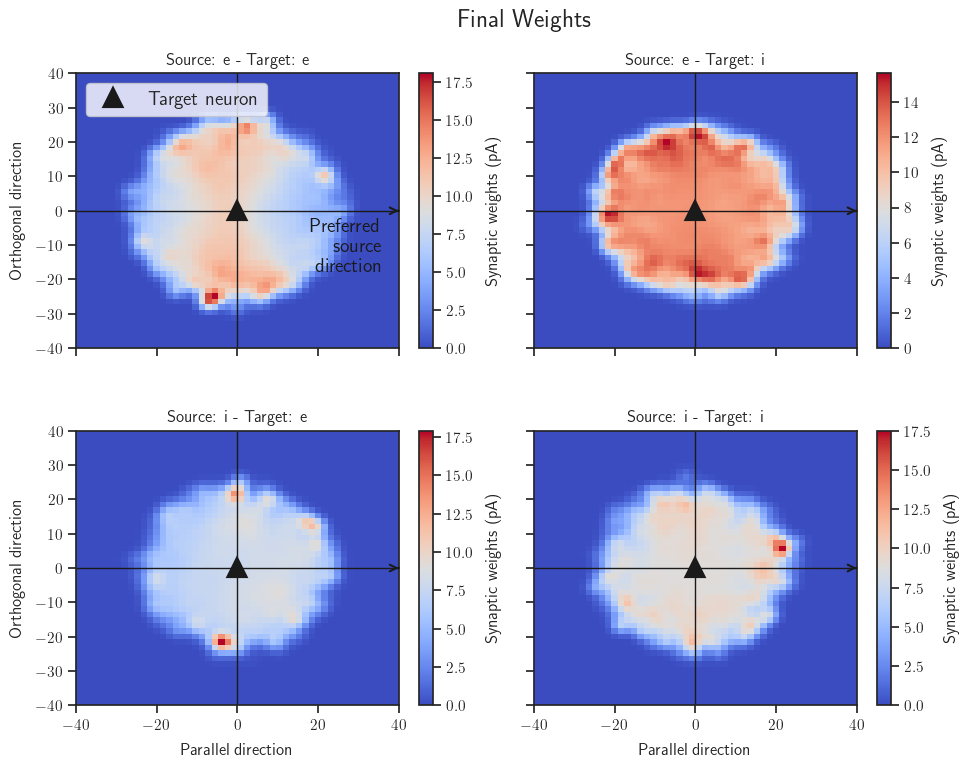

In [16]:
target_cell_types = ['e', 'i']
# target_cell_types = ['e5']
source_cell_types = ['e', 'i']
source_feature = 'DSI' # 'OSI'

fig = plt.figure(figsize=(6 * len(target_cell_types), 4 * len(source_cell_types)), constrained_layout=True)
if len(source_cell_types) * len(target_cell_types) == 4:
    top_title_space = 0.9
else:
    top_title_space = 0.8
gs = gridspec.GridSpec(len(source_cell_types), len(target_cell_types) + 1, width_ratios=[1, 1, 0.035], 
                        wspace=0.2, hspace=0.3, top=top_title_space)
# # Define limits of the histograms
# global_min = 0
# global_max = 20

plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    # Select source and target IDs
    # source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core') & (df[source_feature] > 0.2)].astype(np.int32).values
    source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core')].astype(np.int32).values
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = df.index[(df['ei'] == target_cell_type) & (df['region'] == 'core') ].astype(np.int32).values
        # target_tf_ids = df.index[(df['pop_name'].str.contains(target_cell_type)) & (df['region'] == 'core') ].astype(np.int32).values
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = np.abs(model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids)
        final_value_masked = np.abs(model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids)
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
        target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)
        # Calculate differences in coordinates
        source_azimuth = df.loc[source_indices, 'azimuth'].values
        target_azimuth = df.loc[target_indices, 'azimuth'].values
        source_elevation = df.loc[source_indices, 'elevation'].values
        target_elevation = df.loc[target_indices, 'elevation'].values
         # source position in the target centered coordinate system
        diff_azimuth = source_azimuth - target_azimuth
        diff_elevation = source_elevation - target_elevation
        # # rotate to the axis of target neuron tuning angle
        source_tuning_angle_rad = np.radians(source_tuning_angles)
        cos_angles = np.cos(source_tuning_angle_rad)
        sin_angles = np.sin(source_tuning_angle_rad)
        # Rotate the sources coordinates according to the target neuron preferred direction
        diff_x_rot = diff_azimuth * cos_angles + diff_elevation * sin_angles
        diff_z_rot = diff_elevation * cos_angles - diff_azimuth * sin_angles

        bins = 50
        # area_dimensions = [[-80, 80], [-80, 80]]
        area_dimensions = [[-40, 40], [-40, 40]]
        # area_dimensions = [[-10, 10], [-10, 10]]

        hist, xedges_parallel, yedges_parallel = np.histogram2d(diff_x_rot, diff_z_rot, bins=bins, range=area_dimensions, weights=final_value_masked)
        count_hist, _, _ = np.histogram2d(diff_x_rot, diff_z_rot, range=area_dimensions, bins=bins)
        hist = np.divide(hist, count_hist, out=np.zeros_like(hist), where=count_hist != 0)
        # Apply Gaussian filter to histograms
        sigma = 1
        hist_filtered = gaussian_filter(hist, sigma=sigma)
        ax = plt.subplot(gs[row, col])
        im_filtered = ax.imshow(hist_filtered.T, origin='lower', 
                                        extent=[xedges_parallel[0], xedges_parallel[-1], yedges_parallel[0], yedges_parallel[-1]], 
                                        aspect='auto', cmap='coolwarm') #, vmin=global_min, vmax=global_max)
        ax.axhline(0, color='k', lw=1)
        ax.axvline(0, color='k', lw=1)
        ax.annotate('', xy=(ax.get_xlim()[1], 0), xytext=(ax.get_xlim()[1]-0.1, 0),
                    arrowprops=dict(arrowstyle='->', color='k', lw=1.5))
        cbar = plt.colorbar(im_filtered, ax=ax)
        cbar.set_label('Synaptic weights (pA)')
        if col == 0:
            ax.set_ylabel('Orthogonal direction', fontsize=12)                        
        if col != 0:
            plt.setp(ax.get_yticklabels(), visible=False)   
        if row == len(source_cell_types) - 1:
            ax.set_xlabel('Parallel direction')
        else:
            plt.setp(ax.get_xticklabels(), visible=False)

        ax.plot(0, 0, 'k^', markersize=12, markeredgewidth=3, label='Target neuron')
        if plot_index == 0:
            # Position for the centered text at the right end of the x-axis
            x_right = x_right = ax.get_xlim()[1] - 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # Move left by 10% of x-axis range
            y_position = -0.025 * (ax.get_ylim()[1] - ax.get_ylim()[0])
            ax.text(x_right, y_position,
                    'Preferred \n source \n direction', color='k', ha='right', va='top', fontsize=14, weight='bold')
            ax.legend(loc='upper left', fontsize = 14)

        ax.set_title(f'Source: {source_cell_type} - Target: {target_cell_type}')
        plot_index += 1

fig.suptitle(f'Final Weights', fontsize=18)
plt.show()

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


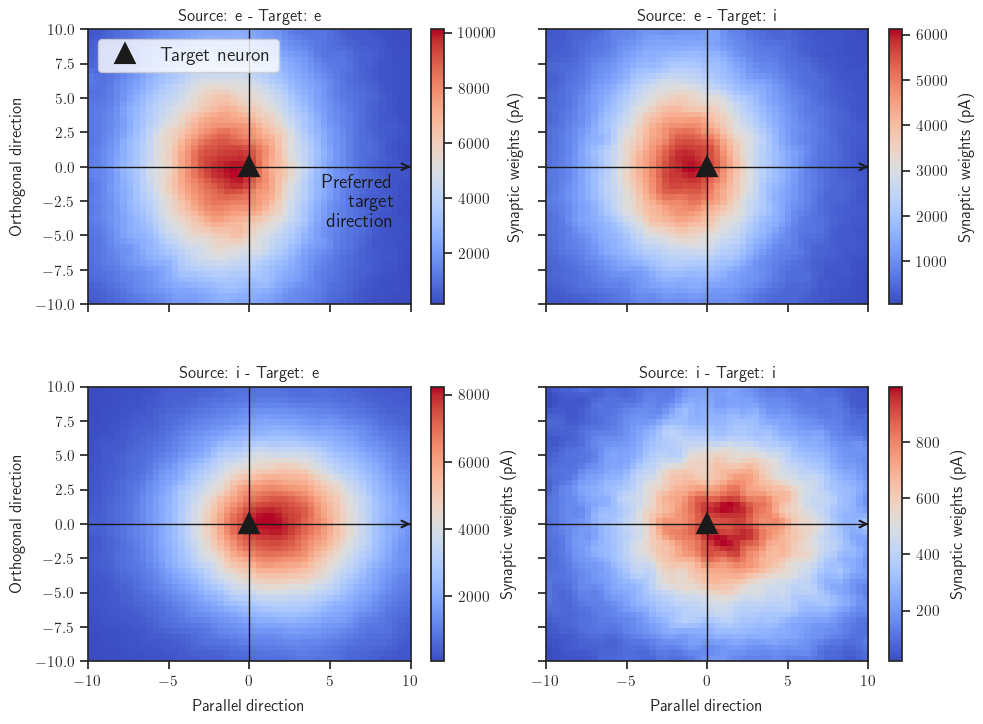

In [17]:
target_cell_types = ['e', 'i']
source_cell_types = ['e', 'i']
source_feature = 'DSI' # 'OSI'

fig = plt.figure(figsize=(6 * len(target_cell_types), 4 * len(source_cell_types)), constrained_layout=True)
if len(source_cell_types) * len(target_cell_types) == 4:
    top_title_space = 0.9
else:
    top_title_space = 0.8
gs = gridspec.GridSpec(len(source_cell_types), len(target_cell_types) + 1, width_ratios=[1, 1, 0.035], 
                        wspace=0.2, hspace=0.3, top=top_title_space)
# Define limits of the histograms
# global_min = 0
# global_max = 20

plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    # Select source and target IDs
    # source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core') & (df[source_feature] > 0.2)].astype(np.int32).values
    source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core')].astype(np.int32).values
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = df.index[(df['ei'] == target_cell_type) & (df['region'] == 'core') ].astype(np.int32).values
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = np.abs(model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids)
        final_value_masked = np.abs(model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids)
        # Calculate tuning angle differences
        # source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
        target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
        # Calculate differences in coordinates
        source_azimuth = df.loc[source_indices, 'azimuth'].values
        target_azimuth = df.loc[target_indices, 'azimuth'].values
        source_elevation = df.loc[source_indices, 'elevation'].values
        target_elevation = df.loc[target_indices, 'elevation'].values

        # source position in the target centered coordinate system
        diff_azimuth = source_azimuth - target_azimuth
        diff_elevation = source_elevation - target_elevation
        # get the target neuron angle to define the rotation
        target_tuning_angle_rad = np.radians(target_tuning_angles)
        cos_angles = np.cos(target_tuning_angle_rad)
        sin_angles = np.sin(target_tuning_angle_rad)
        # Rotate the sources coordinates according to the target neuron preferred direction
        diff_x_rot = diff_azimuth * cos_angles + diff_elevation * sin_angles
        diff_z_rot = diff_elevation * cos_angles - diff_azimuth * sin_angles

        bins = 50
        # data_2d = np.column_stack((diff_azimuth_rot, diff_elevation_rot))
        # bins_x, bins_y = utils.freedman_diaconis_bin_sizes(data_2d, returnas="bins")
        # area_dimensions = [[-40, 40], [-40, 40]]
        area_dimensions = [[-10, 10], [-10, 10]]

        hist, xedges_parallel, yedges_parallel = np.histogram2d(diff_x_rot, diff_z_rot, bins=bins, range=area_dimensions, weights=final_value_masked)
        count_hist, _, _ = np.histogram2d(diff_x_rot, diff_z_rot, range=area_dimensions, bins=bins)
        # hist, xedges_parallel, yedges_parallel = np.histogram2d(diff_azimuth_rot, diff_elevation_rot, bins=[bins_x, bins_y], range=area_dimensions, weights=final_value_masked)
        # count_hist, _, _ = np.histogram2d(diff_azimuth_rot, diff_elevation_rot, range=area_dimensions, bins=[bins_x, bins_y])

        # hist = np.divide(hist, count_hist, out=np.zeros_like(hist), where=count_hist != 0)
        # Apply Gaussian filter to histograms
        sigma = 1
        hist_filtered = gaussian_filter(hist, sigma=sigma)
        ax = plt.subplot(gs[row, col])
        im_filtered = ax.imshow(hist_filtered.T, origin='lower', 
                                        extent=[xedges_parallel[0], xedges_parallel[-1], yedges_parallel[0], yedges_parallel[-1]], 
                                        aspect='auto', cmap='coolwarm') #, vmin=7, vmax=11
        ax.axhline(0, color='k', lw=1)
        ax.axvline(0, color='k', lw=1)
        ax.annotate('', xy=(ax.get_xlim()[1], 0), xytext=(ax.get_xlim()[1]-0.1, 0),
                    arrowprops=dict(arrowstyle='->', color='k', lw=1.5))
        cbar = plt.colorbar(im_filtered, ax=ax)
        cbar.set_label('Synaptic weights (pA)')
        if col == 0:
            ax.set_ylabel('Orthogonal direction', fontsize=12)                        
        if col != 0:
            plt.setp(ax.get_yticklabels(), visible=False)   
        if row == len(source_cell_types) - 1:
            ax.set_xlabel('Parallel direction')
        else:
            plt.setp(ax.get_xticklabels(), visible=False)

        ax.plot(0, 0, 'k^', markersize=12, markeredgewidth=3, label='Target neuron')
        if plot_index == 0:
            # Position for the centered text at the right end of the x-axis
            x_right = x_right = ax.get_xlim()[1] - 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # Move left by 10% of x-axis range
            y_position = -0.025 * (ax.get_ylim()[1] - ax.get_ylim()[0])
            ax.text(x_right, y_position,
                    'Preferred \n target \n direction', color='k', ha='right', va='top', fontsize=14, weight='bold')
            ax.legend(loc='upper left', fontsize = 14)

        ax.set_title(f'Source: {source_cell_type} - Target: {target_cell_type}')
        plot_index += 1

# fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
plt.show()

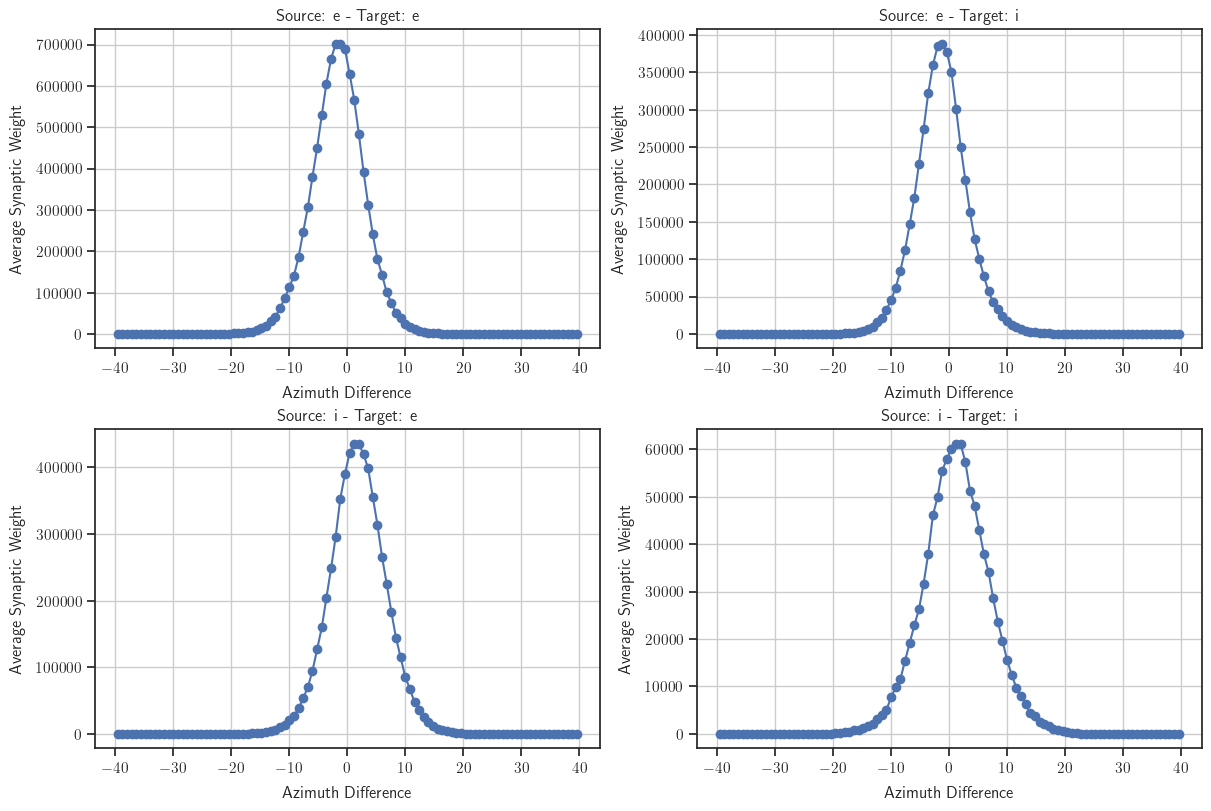

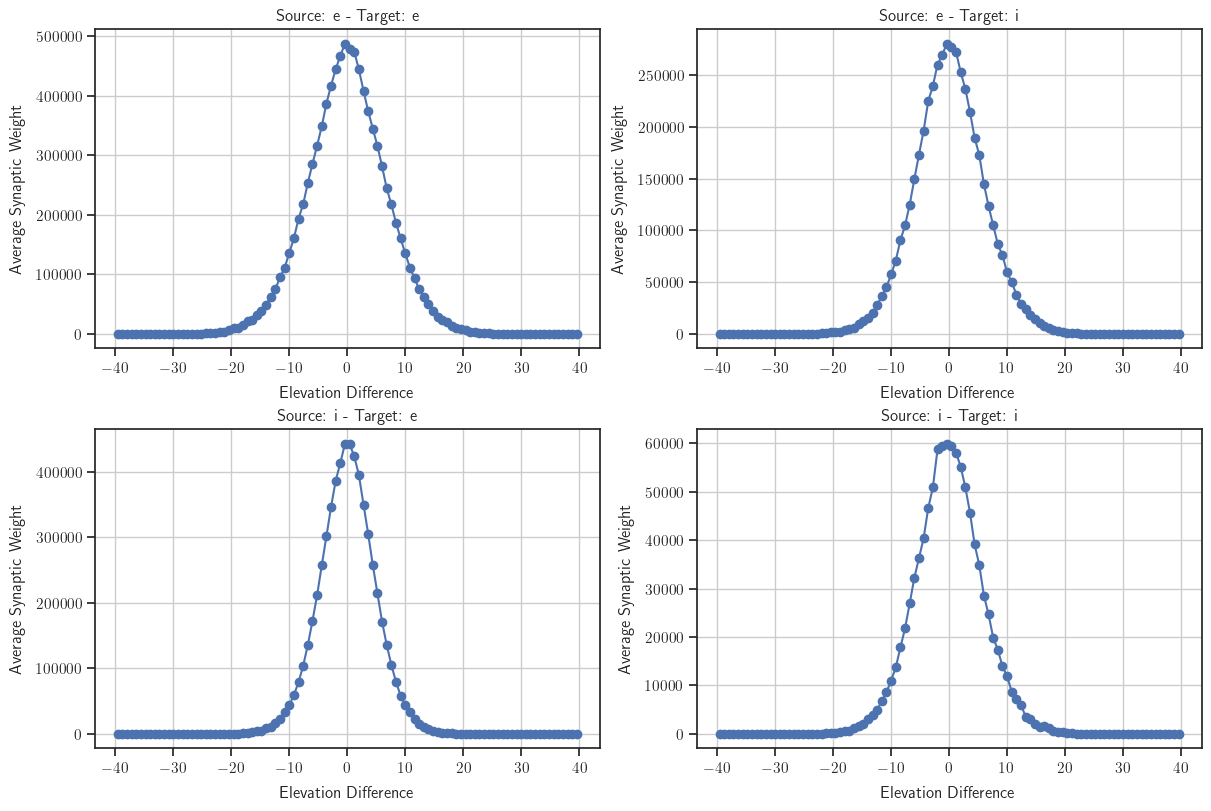

In [18]:
target_cell_types = ['e', 'i']
source_cell_types = ['e', 'i']
source_feature = 'DSI'  # 'OSI'

# Create figures for azimuth and elevation
fig_azimuth = plt.figure(figsize=(6 * len(target_cell_types), 4 * len(source_cell_types)), constrained_layout=True)
fig_elevation = plt.figure(figsize=(6 * len(target_cell_types), 4 * len(source_cell_types)), constrained_layout=True)

# Create gridspecs
gs_azimuth = gridspec.GridSpec(len(source_cell_types), len(target_cell_types), figure=fig_azimuth)
gs_elevation = gridspec.GridSpec(len(source_cell_types), len(target_cell_types), figure=fig_elevation)

# Define bins and area dimensions
bins = 100
area_dimensions = [[-40, 40], [-40, 40]]  # Adjust as needed

for row, source_cell_type in enumerate(source_cell_types):
    # Select source IDs
    # source_tf_ids = df.index[
    #     (df['ei'] == source_cell_type) & (df['region'] == 'core') & (df[source_feature] > 0.2)
    # ].astype(np.int32).values
    source_tf_ids = df.index[
        (df['ei'] == source_cell_type) & (df['region'] == 'core')
    ].astype(np.int32).values
    for col, target_cell_type in enumerate(target_cell_types):
        # Select target IDs
        target_tf_ids = df.index[
            (df['ei'] == target_cell_type) & (df['region'] == 'core')
        ].astype(np.int32).values

        # Create masks and select indices
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]

        # Get synaptic weights
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        final_value_masked = np.abs(model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids)

        # Calculate differences in coordinates
        # source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
        target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
        source_azimuth = df.loc[source_indices, 'azimuth'].values
        target_azimuth = df.loc[target_indices, 'azimuth'].values
        source_elevation = df.loc[source_indices, 'elevation'].values
        target_elevation = df.loc[target_indices, 'elevation'].values

        # source position in the target centered coordinate system
        diff_azimuth = source_azimuth - target_azimuth
        diff_elevation = source_elevation - target_elevation
        # # rotate to the axis of target neuron tuning angle
        target_tuning_angle_rad = np.radians(target_tuning_angles)
        cos_angles = np.cos(target_tuning_angle_rad)
        sin_angles = np.sin(target_tuning_angle_rad)
        # Rotate the sources coordinates according to the target neuron preferred direction
        diff_x_rot = diff_azimuth * cos_angles + diff_elevation * sin_angles
        diff_z_rot = diff_elevation * cos_angles - diff_azimuth * sin_angles

        # Compute histograms for azimuth differences
        hist_x_sum, bin_edges_x = np.histogram(
            diff_x_rot, bins=bins, range=area_dimensions[0], weights=final_value_masked
        )
        hist_x_count, _ = np.histogram(diff_x_rot, bins=bins, range=area_dimensions[0])
        hist_x_avg = np.divide(
            hist_x_sum, hist_x_count, out=np.zeros_like(hist_x_sum), where=hist_x_count != 0
        )
        bin_centers_x = (bin_edges_x[:-1] + bin_edges_x[1:]) / 2

        # Compute histograms for elevation differences
        hist_z_sum, bin_edges_z = np.histogram(
            diff_z_rot, bins=bins, range=area_dimensions[1], weights=final_value_masked
        )
        hist_z_count, _ = np.histogram(diff_z_rot, bins=bins, range=area_dimensions[1])
        hist_z_avg = np.divide(
            hist_z_sum, hist_z_count, out=np.zeros_like(hist_z_sum), where=hist_z_count != 0
        )
        bin_centers_z = (bin_edges_z[:-1] + bin_edges_z[1:]) / 2

        # Plot azimuth marginal distribution
        ax_azimuth = fig_azimuth.add_subplot(gs_azimuth[row, col])
        ax_azimuth.plot(bin_centers_x, hist_x_sum, marker='o', linestyle='-')
        ax_azimuth.set_xlabel('Azimuth Difference')
        ax_azimuth.set_ylabel('Average Synaptic Weight')
        ax_azimuth.set_title(f'Source: {source_cell_type} - Target: {target_cell_type}')
        ax_azimuth.grid(True)

        # Plot elevation marginal distribution
        ax_elevation = fig_elevation.add_subplot(gs_elevation[row, col])
        ax_elevation.plot(bin_centers_z, hist_z_sum, marker='o', linestyle='-')
        ax_elevation.set_xlabel('Elevation Difference')
        ax_elevation.set_ylabel('Average Synaptic Weight')
        ax_elevation.set_title(f'Source: {source_cell_type} - Target: {target_cell_type}')
        ax_elevation.grid(True)

plt.show()


## SYNAPSES SCATTERING (CONNECTIONS AND WEIGHTS) IN AZIMUTH AND ELEVATION

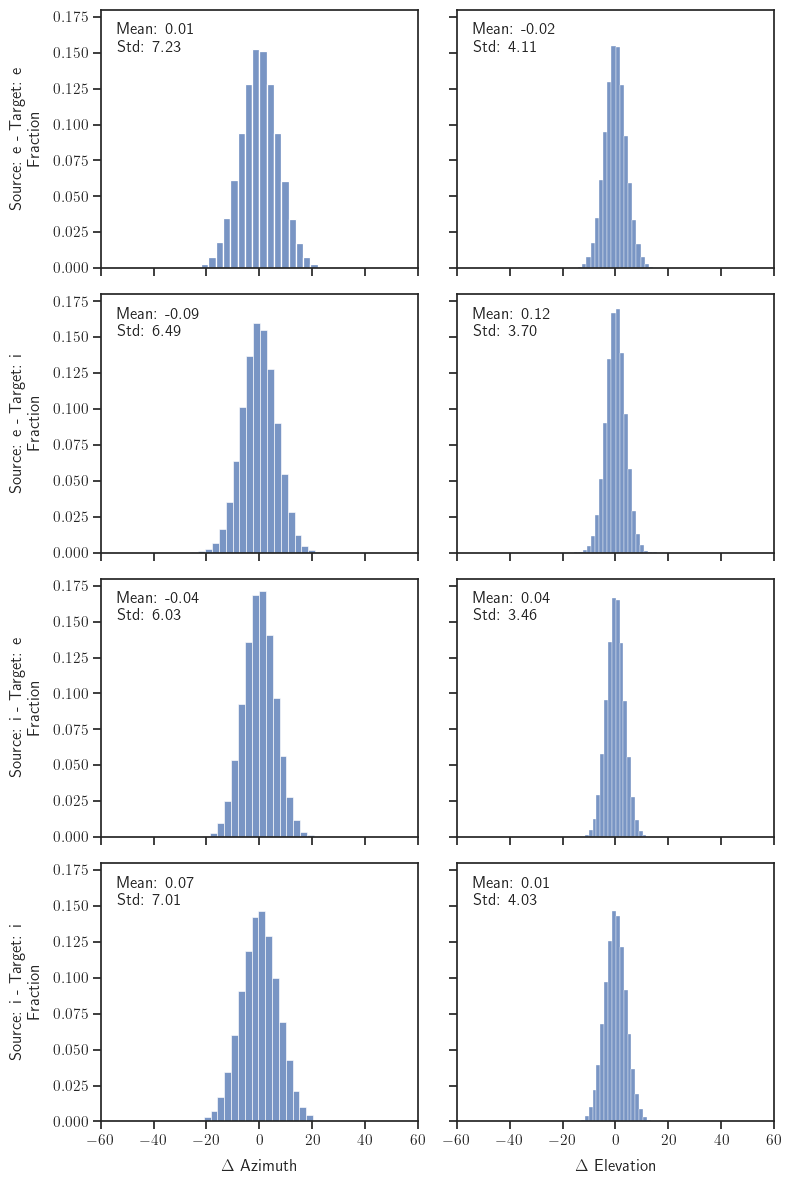

In [19]:
target_cell_types = ['e', 'i']
source_cell_types = ['e', 'i']

fig, axs = plt.subplots(len(source_cell_types) * len(target_cell_types), 2, figsize=(8, 6*len(source_cell_types)), sharex=True, sharey=True)
# axs = axs.flatten()
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    for col, target_cell_type in enumerate(target_cell_types):
        source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core')].astype(np.int32).values
        target_tf_ids = df.index[(df['ei'] == target_cell_type) & (df['region'] == 'core')].astype(np.int32).values
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Calculate differences in coordinates
        source_azimuth = df.loc[source_indices, 'azimuth'].values
        target_azimuth = df.loc[target_indices, 'azimuth'].values
        source_elevation = df.loc[source_indices, 'elevation'].values
        target_elevation = df.loc[target_indices, 'elevation'].values
        diff_x = source_azimuth - target_azimuth
        diff_z = source_elevation - target_elevation
        # Calculate statistics
        mean_diff_x = np.mean(diff_x)
        std_diff_x = np.std(diff_x)
        mean_diff_z = np.mean(diff_z)
        std_diff_z = np.std(diff_z)
        # Plot the distributions of diff x and diff z
        sns.histplot(diff_x, stat='proportion', bins=20, ax=axs[plot_index, 0])
        axs[plot_index, 0].set_xlim(-60, 60)
        axs[plot_index, 0].set_xlabel(r'$\Delta$ Azimuth')
        axs[plot_index, 0].set_ylabel(f'Source: {source_cell_type} - Target: {target_cell_type}\n Fraction')
        axs[plot_index, 0].text(0.05, 0.95, f'Mean: {mean_diff_x:.2f}\nStd: {std_diff_x:.2f}', transform=axs[plot_index, 0].transAxes, 
                                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        sns.histplot(diff_z, stat='proportion', bins=20, ax=axs[plot_index, 1])
        axs[plot_index, 1].set_xlim(-60, 60)
        axs[plot_index, 1].set_xlabel(r'$\Delta$ Elevation')
        axs[plot_index, 1].set_ylabel('Fraction')
        axs[plot_index, 1].text(0.05, 0.95, f'Mean: {mean_diff_z:.2f}\nStd: {std_diff_z:.2f}', transform=axs[plot_index, 1].transAxes, 
                                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        plot_index += 1

# fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
plt.tight_layout()

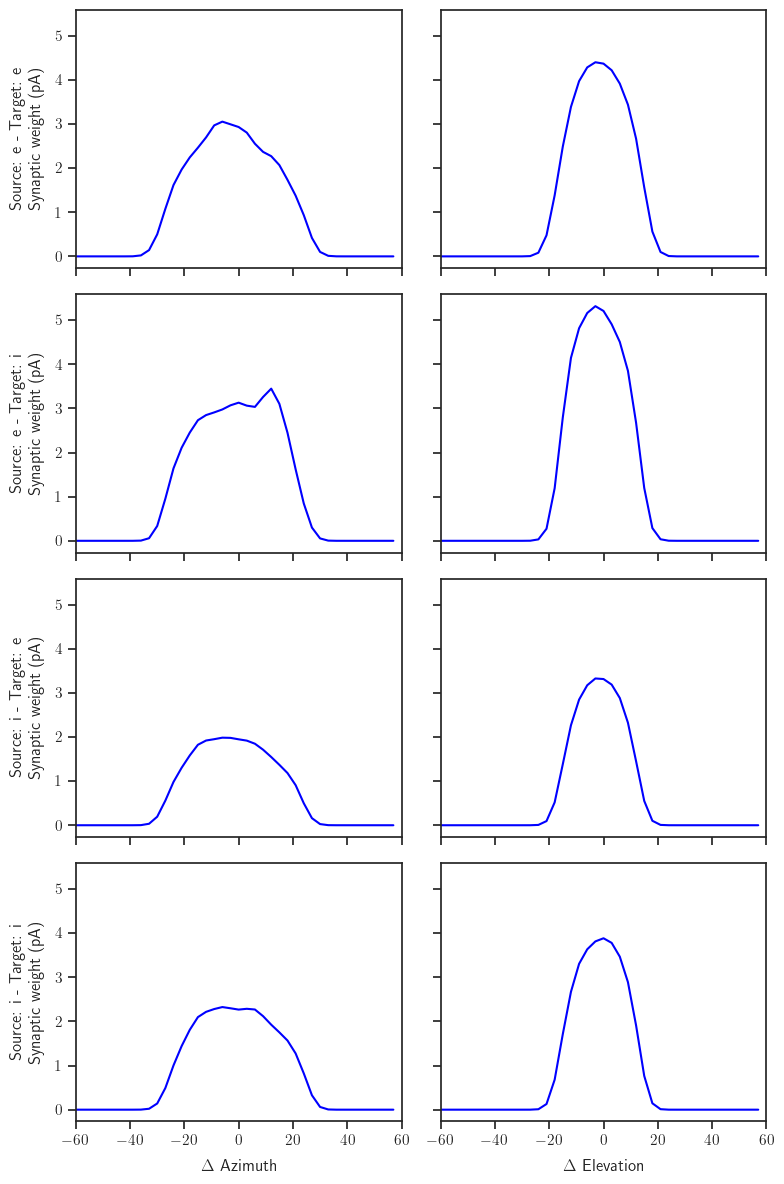

In [20]:
cell_types = ['e', 'i']
source_cell_types = ['e', 'i']

fig, axs = plt.subplots(len(source_cell_types) * len(cell_types), 2, figsize=(8, 6*len(source_cell_types)), sharex=True, sharey=True)
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core')].astype(np.int32).values
    for col, target_cell_type in enumerate(cell_types):
        target_tf_ids = df.index[(df['ei'] == target_cell_type) & (df['region'] == 'core') ].astype(np.int32).values
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = np.abs(model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids)
        final_value_masked = np.abs(model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids)
        # # Calculate tuning angle differences
        # source_tuning_angles = source_df.loc[source_indices, 'preferred_angle'].values
        # target_tuning_angles = target_df.loc[target_indices, 'preferred_angle'].values
        # tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        # tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)
        # Calculate differences in coordinates
        source_azimuth = df.loc[source_indices, 'azimuth'].values
        target_azimuth = df.loc[target_indices, 'azimuth'].values
        source_elevation = df.loc[source_indices, 'elevation'].values
        target_elevation = df.loc[target_indices, 'elevation'].values
        diff_x = source_azimuth - target_azimuth
        diff_z = source_elevation - target_elevation
        # target_tuning_angle_rad = np.radians(target_tuning_angles[selected_indices[:, 0]])
        # diff_x_rot = diff_x * np.cos(target_tuning_angle_rad+np.pi) + diff_z * np.sin(target_tuning_angle_rad+np.pi)
        # diff_z_rot = diff_z * np.cos(target_tuning_angle_rad+np.pi) - diff_x * np.sin(target_tuning_angle_rad+np.pi)
        bins = 40  
        area_dimensions = [[-60, 60], [-60, 60]]
        hist, xedges_final, yedges_final = np.histogram2d(diff_z, diff_x, bins=bins, range=area_dimensions, weights=final_value_masked)
        count_hist, _, _ = np.histogram2d(diff_z, diff_x, range=area_dimensions, bins=bins)
        hist = np.divide(hist, count_hist, out=np.zeros_like(hist), where=count_hist != 0)
        # Apply Gaussian filter to histograms
        sigma = 1  
        hist_filtered = gaussian_filter(hist, sigma=sigma)
        # Calculate Marginal Distributions
        marginal_final_x = np.mean(hist_filtered, axis=0)
        marginal_final_z = np.mean(hist_filtered, axis=1)
        # Plot the distribution of marginal_final_x and marginal_final_z 
        axs[plot_index, 0].plot(xedges_final[:-1], marginal_final_x, color='blue')
        axs[plot_index, 0].set_xlim(-60, 60)
        axs[plot_index, 0].set_ylabel(f'Source: {source_cell_type} - Target: {target_cell_type}\n Synaptic weight (pA)')
        axs[plot_index, 1].plot(yedges_final[:-1], marginal_final_z, color='blue')
        axs[plot_index, 1].set_xlim(-60, 60)
        plot_index += 1

axs[plot_index-1, 0].set_xlabel(r'$\Delta$ Azimuth')
axs[plot_index-1, 1].set_xlabel(r'$\Delta$ Elevation')
# fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
plt.tight_layout()
plt.show()

## OSI/DSI ANALYSIS AND LIKE-LIKE RULES

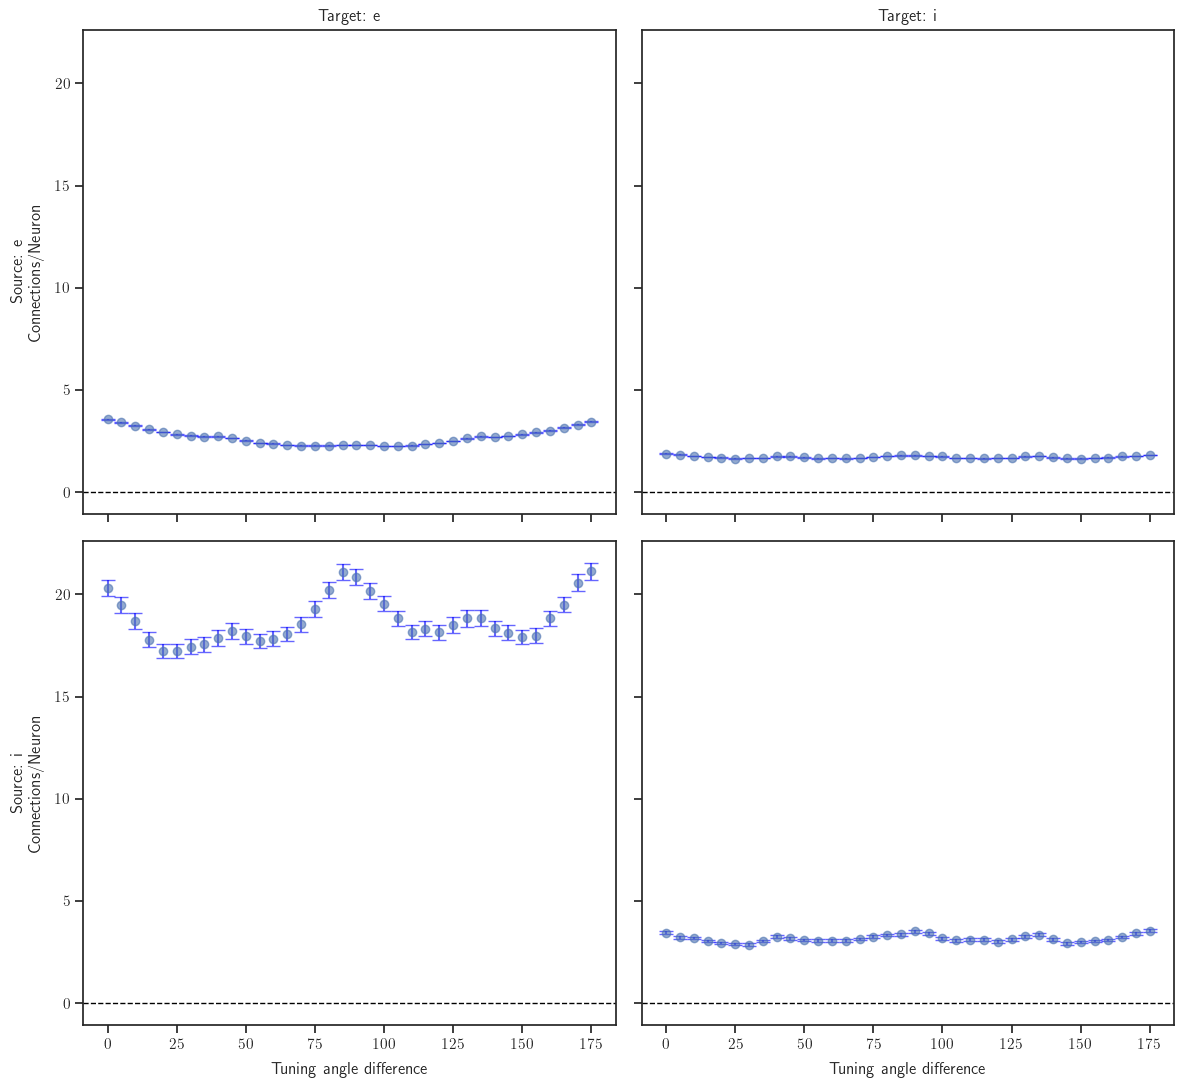

In [21]:
# %%timeit
areas = ['v1', 'lm']
target_cell_types = ['e', 'i']
source_cell_types = ['e', 'i']

fig, axs = plt.subplots(len(source_cell_types), len(target_cell_types), figsize=(12, 6*len(source_cell_types)), sharex=True, sharey=True)
axs = axs.flatten()
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    source_tf_ids = df.index[(df['ei'] == source_cell_type)].astype(np.int32).values
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = df.index[(df['ei'] == target_cell_type) & (df['region'] == 'core') ].astype(np.int32).values
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
        target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)

        bins = np.arange(0, 181, 5)
        bin_counts = np.zeros(len(bins) - 1)
        bin_errors = np.zeros(len(bins) - 1)
        bin_indices = np.digitize(tuning_angle_diff, bins) - 1
        # Loop over the bins to calculate mean connections per neuron and their errors
        for i in range(len(bins) - 1):
            # Get the connections that fall into the current bin
            connections_in_bin = selected_indices[bin_indices == i]
            
            if connections_in_bin.size > 0:
                # Unique source neurons and counts in the current bin
                unique_source_neurons, neuron_indices, counts = np.unique(connections_in_bin[:, 1], 
                                                                        return_inverse=True, return_counts=True)
                num_neurons_in_bin = unique_source_neurons.size
                
                if num_neurons_in_bin > 0:
                    # Calculate mean and error for the bin using NumPy operations
                    bin_counts[i] = np.mean(counts)
                    # Calculate the standard deviation and SEM for the bin
                    std_dev = np.std(counts, ddof=1)  # ddof=1 for sample standard deviation
                    bin_errors[i] = std_dev / np.sqrt(num_neurons_in_bin)
    
        # Plot the histogram
        axs[plot_index].errorbar(bins[:-1], bin_counts, yerr=bin_errors, fmt='o', ecolor='blue', capsize=5, label='Connections/Neuron', alpha=0.6)
        axs[plot_index].axhline(y=0, color='black', linestyle='--', linewidth=1)

        if row == 0:
            axs[plot_index].set_title(f'Target: {target_cell_type}', fontsize=12)
        if col == 0:
            axs[plot_index].set_ylabel(f'Source: {source_cell_type}\nConnections/Neuron', fontsize=12)
        if row == len(source_cell_types) - 1:
            axs[plot_index].set_xlabel(f'Tuning angle difference', fontsize=12)

        # axs[plot_index].grid(True)
        plot_index += 1

# fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

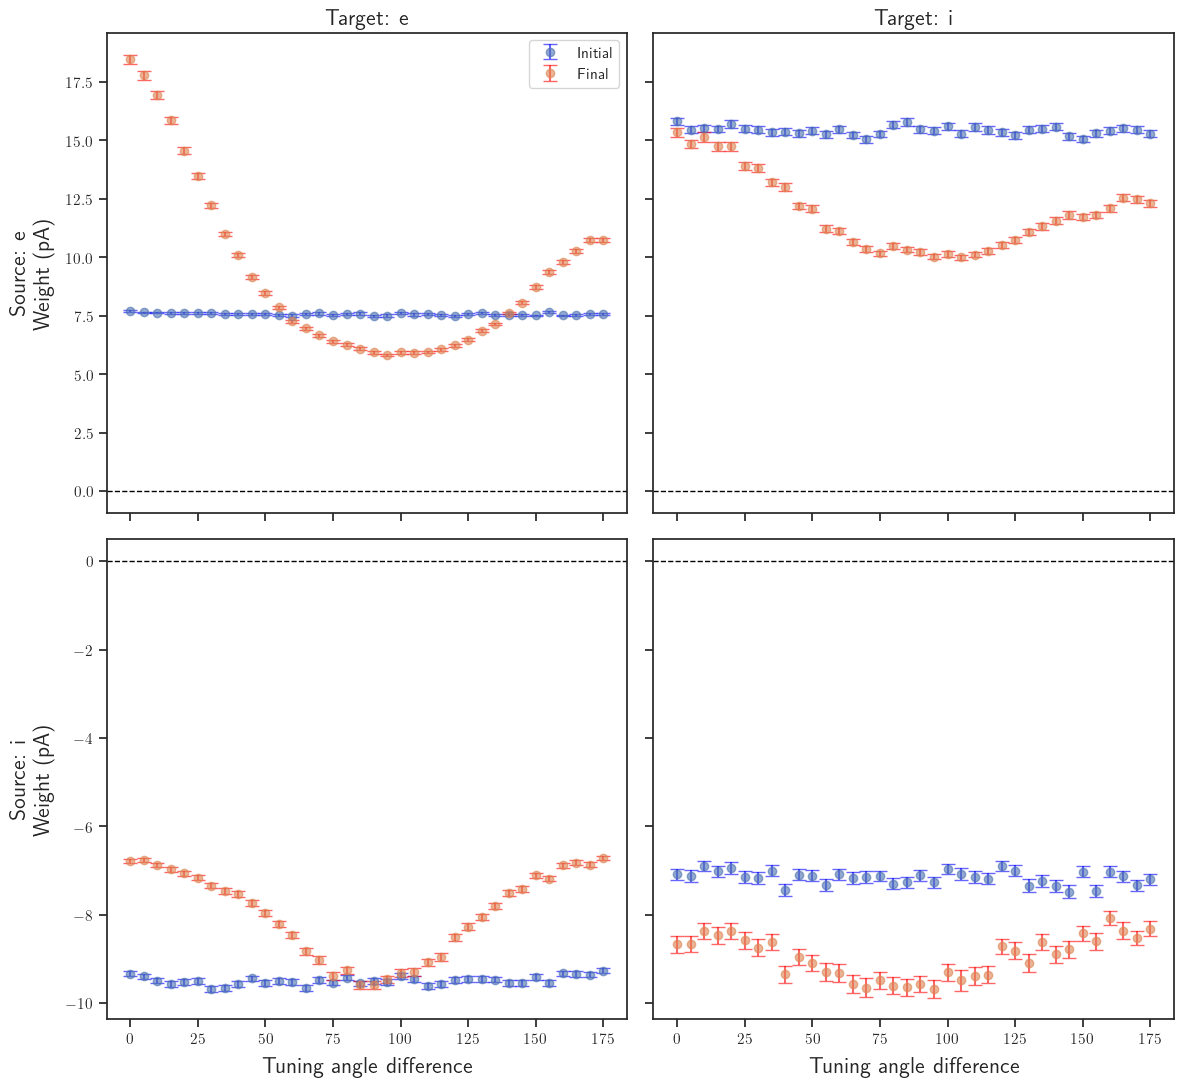

In [22]:
target_cell_types = ['e', 'i']
source_cell_types = ['e', 'i']

fig, axs = plt.subplots(len(source_cell_types), len(target_cell_types), figsize=(12, 6*len(source_cell_types)), sharex=True, sharey='row')
axs = axs.flatten()
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core')].astype(np.int32).values
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = df.index[(df['ei'] == target_cell_type) & (df['region'] == 'core') ].astype(np.int32).values
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids
        final_value_masked = model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
        target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)

        bins = np.arange(0, 181, 5)
        bin_indices = np.digitize(tuning_angle_diff, bins)
        bin_initial_values = np.zeros(len(bins)-1)
        bin_initial_errors = np.zeros(len(bins)-1)
        bin_final_values = np.zeros(len(bins)-1)
        bin_final_errors = np.zeros(len(bins)-1)
        for i in range(1, len(bins)):
            initial_values_in_bin = initial_value_masked[bin_indices == i]
            if initial_values_in_bin.size > 0:
                bin_initial_values[i-1] = np.mean(initial_values_in_bin)
                std_dev_initial = np.std(initial_values_in_bin, ddof=1)
                bin_initial_errors[i-1] = std_dev_initial / np.sqrt(initial_values_in_bin.size)

            final_values_in_bin = final_value_masked[bin_indices == i]
            if final_values_in_bin.size > 0:
                bin_final_values[i-1] = np.mean(final_values_in_bin)
                std_dev_final = np.std(final_values_in_bin, ddof=1)
                bin_final_errors[i-1] = std_dev_final / np.sqrt(final_values_in_bin.size)

        axs[plot_index].errorbar(bins[:-1], bin_initial_values, yerr=bin_initial_errors, fmt='o', ecolor='blue', capsize=5, label='Initial', alpha=0.6)
        axs[plot_index].errorbar(bins[:-1], bin_final_values, yerr=bin_final_errors, fmt='o', ecolor='red', capsize=5, label='Final', alpha=0.6)
        axs[plot_index].axhline(y=0, color='black', linestyle='--', linewidth=1)

        if row == 0:
            axs[plot_index].set_title(f'Target: {target_cell_type}', fontsize=16)
        if col == 0:
            axs[plot_index].set_ylabel(f'Source: {source_cell_type}\nWeight (pA)', fontsize=16)
        if row == len(source_cell_types) - 1:
            axs[plot_index].set_xlabel(r'Tuning angle difference', fontsize=16)
        if row == 0 and col == 0:
            axs[plot_index].legend()

        plot_index += 1

# fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


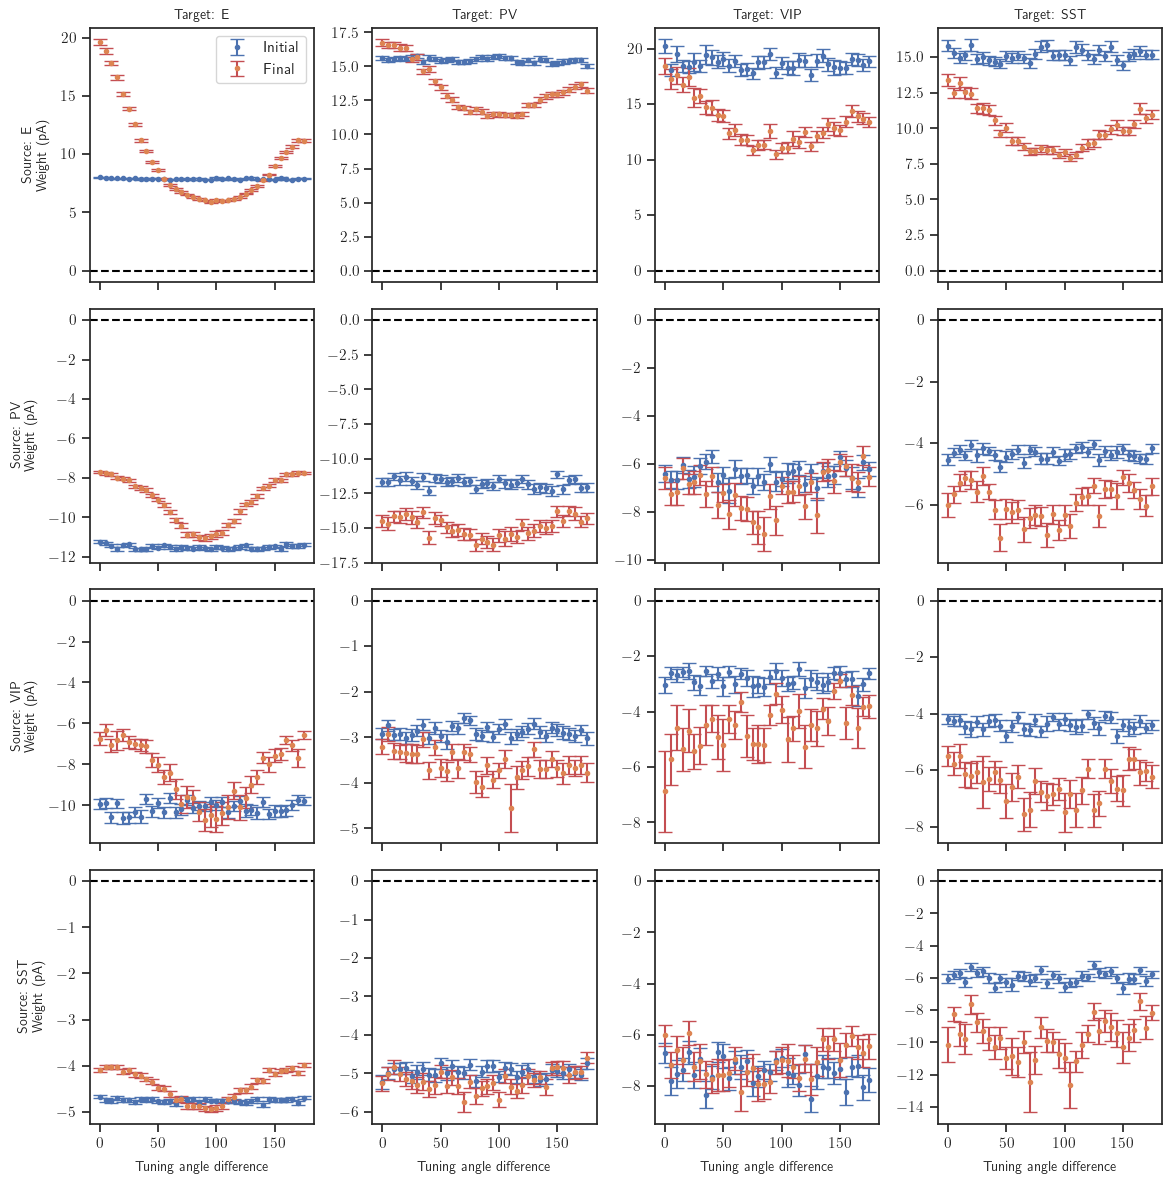

In [23]:
target_cell_types = ['E', 'PV', 'VIP', 'SST'] #['L2/3 Exc', 'L4 Exc', 'L5 Exc', 'L6 Exc']
source_cell_types = ['E', 'PV', 'VIP', 'SST']
# target_cell_types = ['E', 'IT', 'NP', 'PV', 'Htr3a', 'VIP', 'SST'] #['L2/3 Exc', 'L4 Exc', 'L5 Exc', 'L6 Exc']
# source_cell_types = ['E', 'IT', 'NP', 'PV', 'Htr3a', 'VIP', 'SST'] #['E', 'PV', 'VIP', 'SST']
num_subplots = len(source_cell_types)

fig, axs = plt.subplots(len(source_cell_types), len(target_cell_types), figsize=(12, 3*len(source_cell_types)), sharex=True) #, sharey='row')
axs = axs.flatten()
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    source_tf_ids = df.index[(df['cell_type'].str.contains(source_cell_type)) & (df['region'] == 'core')].astype(np.int32).values
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = df.index[(df['cell_type'].str.contains(target_cell_type)) & (df['region'] == 'core')].astype(np.int32).values
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids
        final_value_masked = model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
        target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)

        # take bins of 1 degree and average the weight values in the corresponding bin
        bins = np.arange(0, 181, 5)
        bin_indices = np.digitize(tuning_angle_diff, bins)
        bin_initial_values = np.zeros(len(bins) - 1)
        bin_initial_errors = np.zeros(len(bins) - 1)  # Array to store the standard error of the mean for each bin
        bin_final_values = np.zeros(len(bins) - 1)
        bin_final_errors = np.zeros(len(bins) - 1)  # Array to store the standard error of the mean for each bin
        for i in range(1, len(bins)):
            initial_values_in_bin = initial_value_masked[bin_indices == i]
            if initial_values_in_bin.size > 0:
                bin_initial_values[i-1] = np.mean(initial_values_in_bin)
                std_dev_initial = np.std(initial_values_in_bin, ddof=1)
                bin_initial_errors[i-1] = std_dev_initial / np.sqrt(initial_values_in_bin.size)

            final_values_in_bin = final_value_masked[bin_indices == i]
            if final_values_in_bin.size > 0:
                bin_final_values[i-1] = np.mean(final_values_in_bin)
                std_dev_final = np.std(final_values_in_bin, ddof=1)
                bin_final_errors[i-1] = std_dev_final / np.sqrt(final_values_in_bin.size)

        # plot the average weight values with error bars
        axs[plot_index].errorbar(bins[:-1], bin_initial_values, yerr=bin_initial_errors, fmt='.', ecolor='b', capsize=5, label='Initial')
        axs[plot_index].errorbar(bins[:-1], bin_final_values, yerr=bin_final_errors, fmt='.', ecolor='r', capsize=5, label=f'Final')
        axs[plot_index].axhline(y=0, color='black', linestyle='--')
        if row == 0:
            axs[plot_index].set_title(f'Target: {target_cell_type}', fontsize=10)
        if col == 0:
            axs[plot_index].set_ylabel(f'Source: {source_cell_type}\n Weight (pA)', fontsize=10) #, rotation=0, labelpad=40)
        if row == len(source_cell_types) - 1:
            axs[plot_index].set_xlabel(r'Tuning angle difference', fontsize=10)
        if row == 0 and col == 0:
            axs[plot_index].legend()
        plot_index += 1

# fig.suptitle(f'Src Area: {source_area}, Tgt Area: {target_area}')
plt.tight_layout()
plt.show()

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


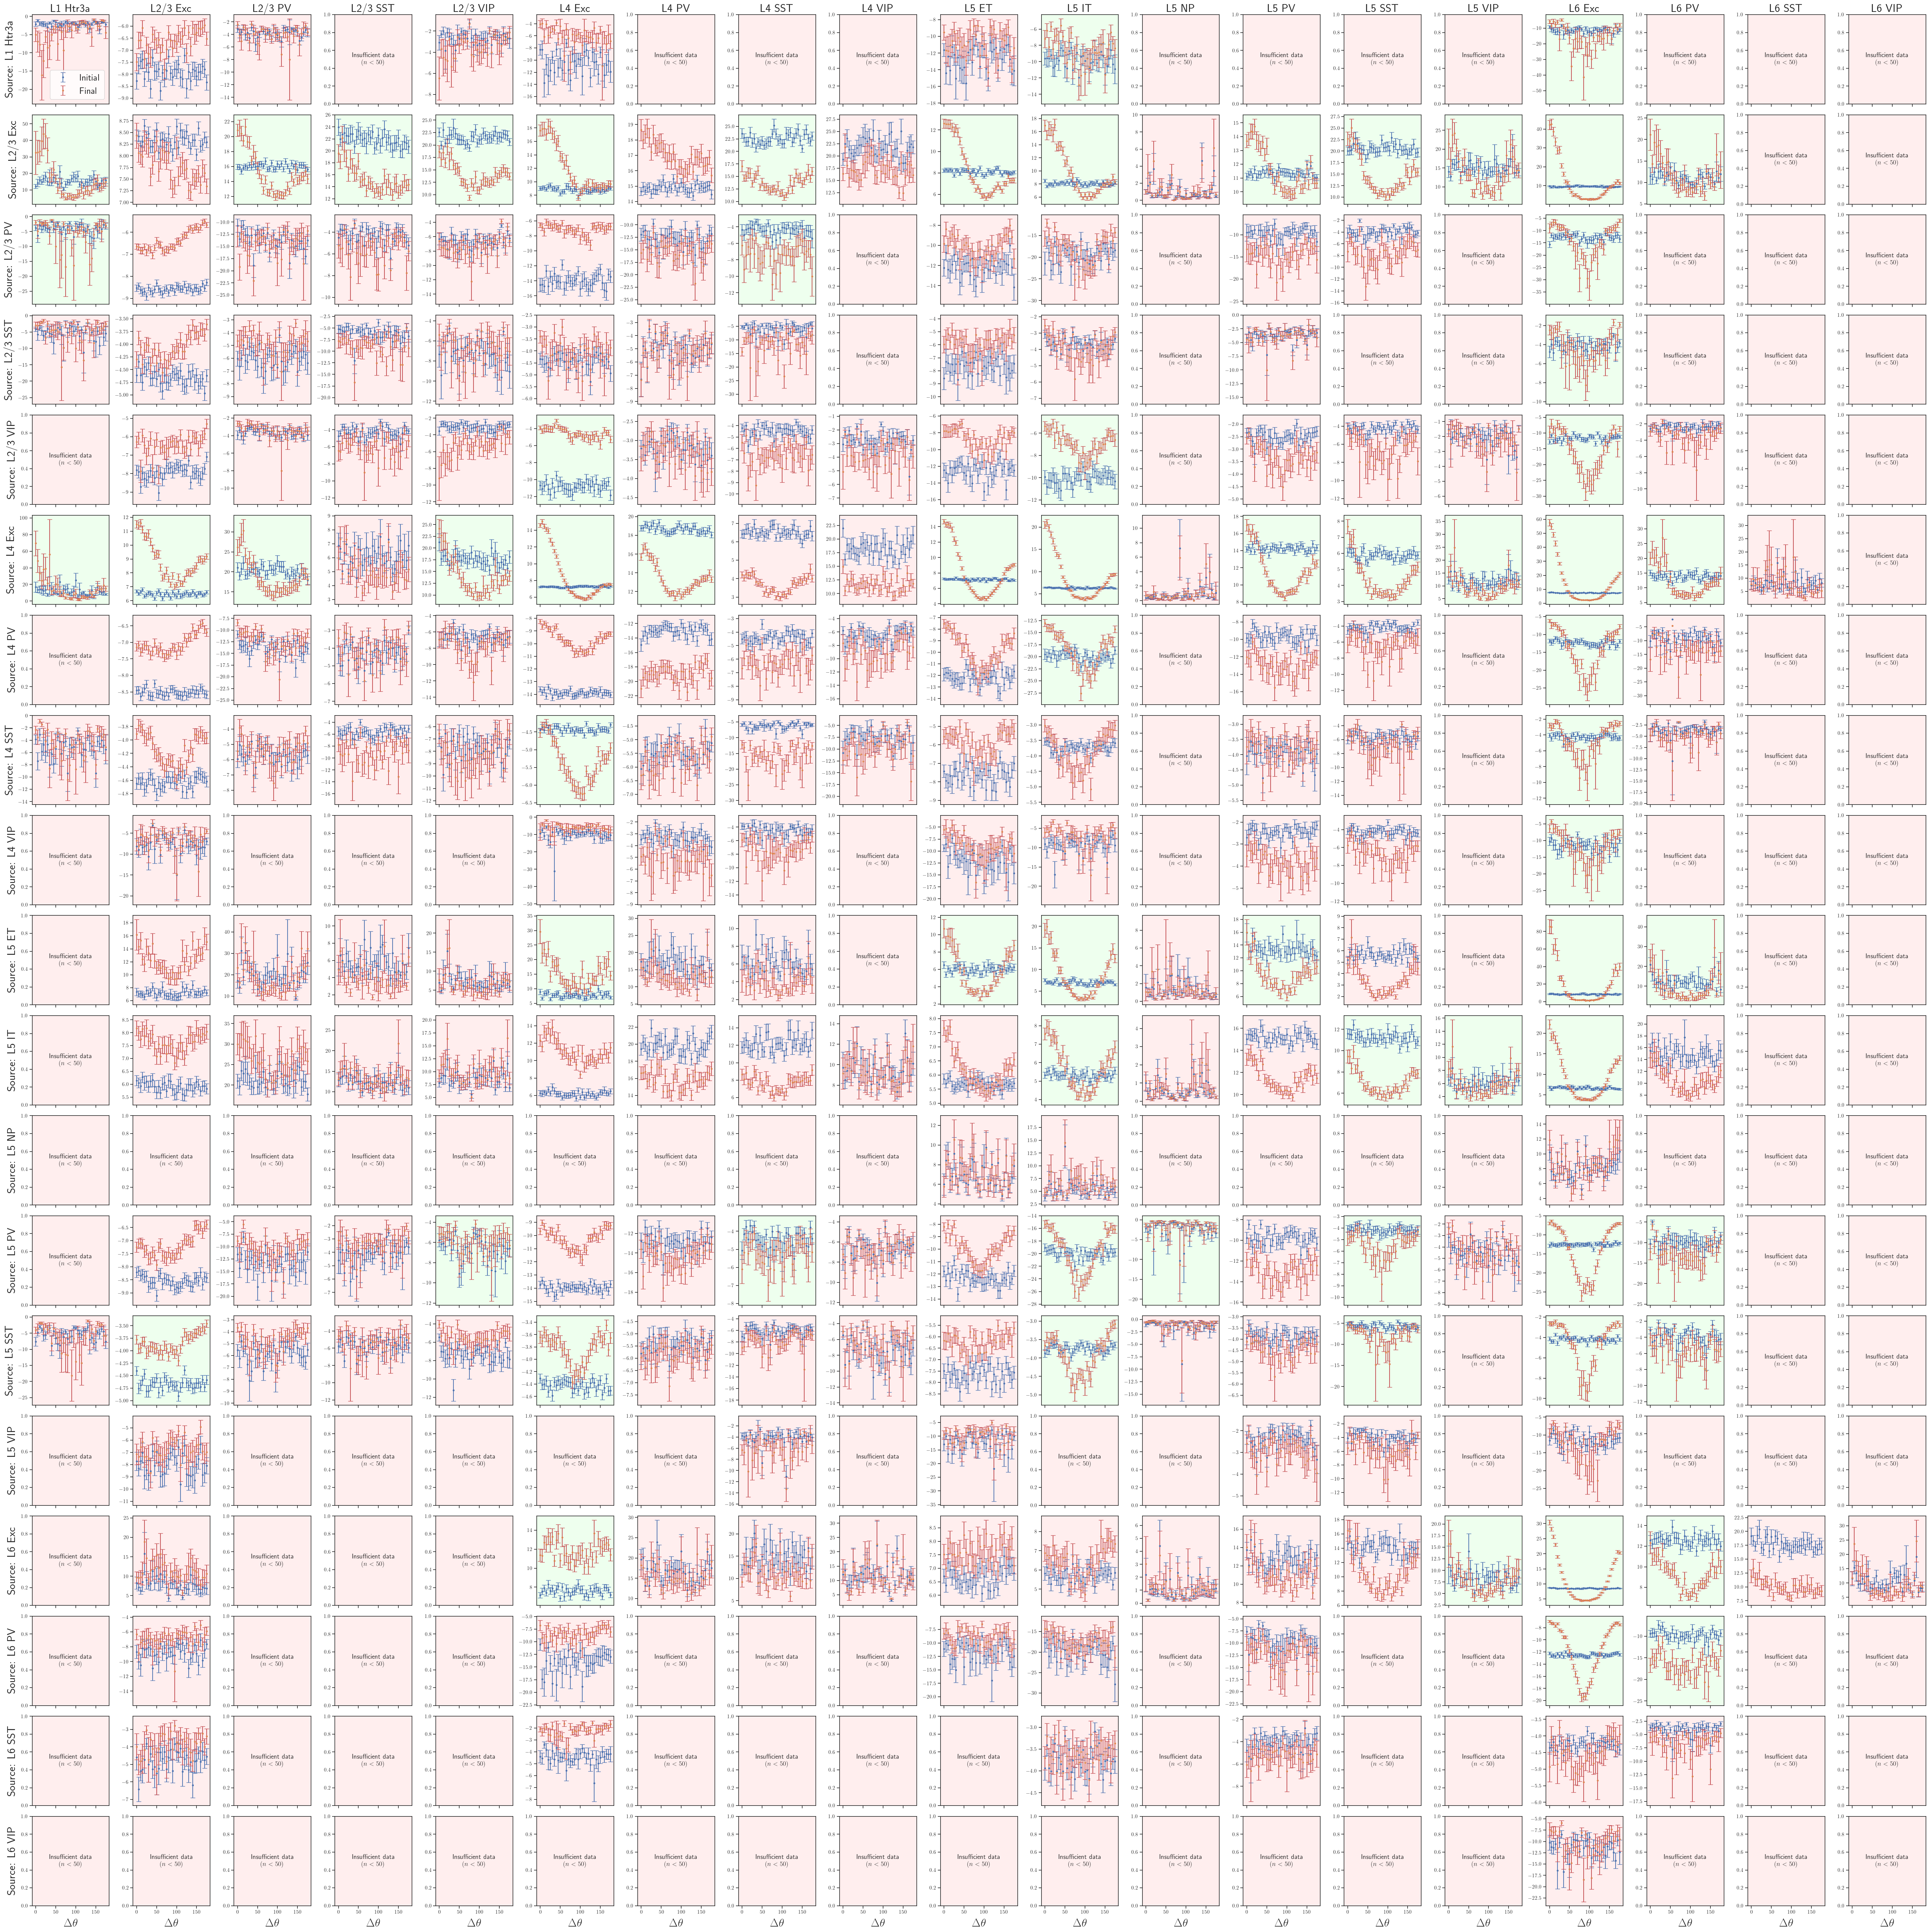

In [36]:
sorted_cell_types = np.sort(list(set(v1_cell_types)))
num_subplots = len(sorted_cell_types)

fig, axs = plt.subplots(num_subplots, num_subplots, figsize=(3*num_subplots, 3*num_subplots), sharex=True)
axs = axs.flatten()

plot_index = -1
for row, source_cell_type in enumerate(sorted_cell_types):
    source_tf_ids = df.index[(df['cell_type'] == source_cell_type) & (df['region'] == 'core')].astype(np.int32).values
    for col, target_cell_type in enumerate(sorted_cell_types):
        plot_index += 1
        target_tf_ids = df.index[(df['cell_type'] == target_cell_type) & (df['region'] == 'core')].astype(np.int32).values
        
        # Set titles and labels for all subplots
        if row == 0:
            axs[plot_index].set_title(f'{target_cell_type}', fontsize=24)
        if col == 0:
            axs[plot_index].set_ylabel(f'Source: {source_cell_type}', fontsize=24)
        if row == len(sorted_cell_types) - 1:
            axs[plot_index].set_xlabel(r'$\Delta \theta$', fontsize=24)
        
        # Create mask for this cell pair
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        
        # Set default background color for insufficient data
        axs[plot_index].set_facecolor('#ffeeee')  # Light red for default
        
        if selected_indices.size > 500:  # ensure sufficient data points
            target_indices = selected_indices[:, 0]
            source_indices = selected_indices[:, 1]
            
            # Mask voltage_scale_node_ids
            voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
            initial_value_masked = model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids
            final_value_masked = model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids
            
            # Calculate tuning angle differences
            source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
            target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
            tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
            tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)
            
            # Run statistical test
            # observed_msd, permuted_msds, p_value = permutation_test_raw_data_numba(
            #     initial_value_masked, final_value_masked, 
            #     source_tuning_angles, target_tuning_angles, 
            #     num_permutations=500
            # )
            observed_mi, p_value = mutual_info_independence_test(
                tuning_angle_diff, final_value_masked, n_permutations=1000
            )
            
            # Set background color based on significance
            if p_value < 0.05:
                axs[plot_index].set_facecolor('#eeffee')  # Light green for significant
            else:
                axs[plot_index].set_facecolor('#ffeeee')  # Light red for non-significant
            
            # Calculate binned values for plotting
            bins = np.arange(0, 181, 5)
            bin_indices = np.digitize(tuning_angle_diff, bins)
            bin_initial_values = np.zeros(len(bins) - 1)
            bin_initial_errors = np.zeros(len(bins) - 1)
            bin_final_values = np.zeros(len(bins) - 1)
            bin_final_errors = np.zeros(len(bins) - 1)
            
            for i in range(1, len(bins)):
                initial_values_in_bin = initial_value_masked[bin_indices == i]
                if initial_values_in_bin.size > 0:
                    bin_initial_values[i-1] = np.mean(initial_values_in_bin)
                    std_dev_initial = np.std(initial_values_in_bin, ddof=1)
                    bin_initial_errors[i-1] = std_dev_initial / np.sqrt(initial_values_in_bin.size)
                
                final_values_in_bin = final_value_masked[bin_indices == i]
                if final_values_in_bin.size > 0:
                    bin_final_values[i-1] = np.mean(final_values_in_bin)
                    std_dev_final = np.std(final_values_in_bin, ddof=1)
                    bin_final_errors[i-1] = std_dev_final / np.sqrt(final_values_in_bin.size)
            
            # Plot the data with error bars
            axs[plot_index].errorbar(bins[:-1], bin_initial_values, yerr=bin_initial_errors, 
                                    fmt='.', ecolor='b', capsize=5, label='Initial')
            axs[plot_index].errorbar(bins[:-1], bin_final_values, yerr=bin_final_errors, 
                                    fmt='.', ecolor='r', capsize=5, label='Final')
            
            # Add a legend only to the first subplot
            if row == 0 and col == 0:
                axs[plot_index].legend(loc='best', fontsize=20)
        
        # Add p-value annotation to the plot
        # axs[plot_index].annotate(f'p = {p_value:.3f}', xy=(0.05, 0.95), 
        #                         xycoords='axes fraction', fontsize=14,
        #                         bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
        else:
            # For insufficient data, just add text annotation
            axs[plot_index].annotate(f'Insufficient data\n' + r'$(n < 50)$', 
                                    xy=(0.5, 0.5), xycoords='axes fraction',
                                    fontsize=14, ha='center', va='center')

plt.tight_layout()
plt.show()

In [40]:
import numba

@numba.njit
def compute_binned_means_numba(values, angles, bins):
    bin_means = np.empty(len(bins) - 1, dtype=np.float64)
    bin_means.fill(np.nan)

    for i in range(len(bins) - 1):
        bin_min = bins[i]
        bin_max = bins[i + 1]
        
        # Identify values within the bin
        bin_sum = 0.0
        bin_count = 0
        for j in range(len(angles)):
            if bin_min <= angles[j] < bin_max:
                bin_sum += values[j]
                bin_count += 1
                
        if bin_count > 0:
            bin_means[i] = bin_sum / bin_count
        else:
            bin_means[i] = np.nan

    return bin_means

@numba.njit
def permutation_test_raw_data_numba(initial_values, final_values, initial_angles, final_angles, 
                                    bins=np.arange(0, 181, 5), num_permutations=5000, random_seed=42):
    np.random.seed(random_seed)

    # Observed statistic
    initial_curve = compute_binned_means_numba(initial_values, initial_angles, bins)
    final_curve = compute_binned_means_numba(final_values, final_angles, bins)
    
    # Compute observed MSD (ignoring NaNs)
    valid_bins = ~np.isnan(initial_curve) & ~np.isnan(final_curve)
    if np.sum(valid_bins) == 0:
        return np.nan, np.full(num_permutations, np.nan), np.nan  # No valid data to compare

    # observed_msd = np.mean((final_curve[valid_bins] - initial_curve[valid_bins]) ** 2)
    observed_msd = np.mean(np.abs(final_curve[valid_bins] - initial_curve[valid_bins]))

     # Combine data into a single array
    n_initial = len(initial_values)
    n_final = len(final_values)
    combined_values = np.concatenate((initial_values, final_values))
    angles_diff = final_angles - initial_angles
    combined_angles = np.concatenate((angles_diff, angles_diff))  # Angles are duplicated, one for each condition
    combined_labels = np.zeros(n_initial + n_final, dtype=np.int32)
    combined_labels[n_initial:] = 1

    permuted_msds = np.empty(num_permutations)
    permuted_msds.fill(np.nan)

    for perm in range(num_permutations):
        # Permute condition labels only (angles remain fixed)
        permuted_labels = np.random.permutation(combined_labels)
        # Separate data according to permuted labels
        perm_initial_values = combined_values[permuted_labels == 0]
        perm_final_values = combined_values[permuted_labels == 1]
        perm_initial_angles = combined_angles[permuted_labels == 0]
        perm_final_angles = combined_angles[permuted_labels == 1]
        # Recompute aggregated curves
        perm_initial_curve = compute_binned_means_numba(perm_initial_values, perm_initial_angles, bins)
        perm_final_curve = compute_binned_means_numba(perm_final_values, perm_final_angles, bins)
        # Compute MSD statistic for this permutation (ignore NaNs)
        valid_perm_bins = ~np.isnan(perm_initial_curve) & ~np.isnan(perm_final_curve)
        if np.sum(valid_perm_bins) == 0:
            continue # skip this permutation if no valid data to compare
            
        # permuted_msd = np.mean((perm_final_curve[valid_perm_bins] - perm_initial_curve[valid_perm_bins]) ** 2)
        permuted_msd = np.mean(np.abs(perm_final_curve[valid_perm_bins] - perm_initial_curve[valid_perm_bins]))
        permuted_msds[perm] = permuted_msd

    # Remove any NaNs from permuted MSDs before computing p-value
    permuted_msds = permuted_msds[~np.isnan(permuted_msds)]
    if permuted_msds.size == 0:
        return observed_msd, permuted_msds, np.nan  # No valid permutations
    
    p_value = (np.sum(permuted_msds >= observed_msd) + 1) / (len(permuted_msds) + 1)

    return observed_msd, permuted_msds, p_value


def permutation_test_raw_data_numba_plots(initial_values, final_values, initial_angles, final_angles, 
                                    bins=np.arange(0, 181, 5), num_permutations=5000, random_seed=42):
    np.random.seed(random_seed)

    # Observed statistic
    initial_curve = compute_binned_means_numba(initial_values, initial_angles, bins)
    final_curve = compute_binned_means_numba(final_values, final_angles, bins)
    
    # Compute observed MSD (ignoring NaNs)
    valid_bins = ~np.isnan(initial_curve) & ~np.isnan(final_curve)
    if np.sum(valid_bins) == 0:
        return np.nan, np.full(num_permutations, np.nan), np.nan  # No valid data to compare

    observed_msd = np.mean(np.abs((final_curve[valid_bins] - initial_curve[valid_bins])))

     # Combine data into a single array
    n_initial = len(initial_values)
    n_final = len(final_values)
    combined_values = np.concatenate((initial_values, final_values))
    angles_diff = final_angles - initial_angles
    combined_angles = np.concatenate((angles_diff, angles_diff))  # Angles are duplicated, one for each condition
    combined_labels = np.zeros(n_initial + n_final, dtype=np.int32)
    combined_labels[n_initial:] = 1

    permuted_msds = np.empty(num_permutations)
    permuted_msds.fill(np.nan)

    for perm in range(num_permutations):
        # Permute condition labels only (angles remain fixed)
        permuted_labels = np.random.permutation(combined_labels)
        # Separate data according to permuted labels
        perm_initial_values = combined_values[permuted_labels == 0]
        perm_final_values = combined_values[permuted_labels == 1]
        perm_initial_angles = combined_angles[permuted_labels == 0]
        perm_final_angles = combined_angles[permuted_labels == 1]
        # Recompute aggregated curves
        perm_initial_curve = compute_binned_means_numba(perm_initial_values, perm_initial_angles, bins)
        perm_final_curve = compute_binned_means_numba(perm_final_values, perm_final_angles, bins)
        # Compute MSD statistic for this permutation (ignore NaNs)
        valid_perm_bins = ~np.isnan(perm_initial_curve) & ~np.isnan(perm_final_curve)
        if np.sum(valid_perm_bins) == 0:
            continue # skip this permutation if no valid data to compare
            
        permuted_msd = np.mean(np.abs(perm_final_curve[valid_perm_bins] - perm_initial_curve[valid_perm_bins]))
        permuted_msds[perm] = permuted_msd

        if permuted_msd  >= observed_msd:
            fig, ax = plt.subplots(figsize=(10, 6))
            plt.plot(bins[:-1], perm_initial_curve, '.', color='blue', alpha=0.5)
            plt.plot(bins[:-1], perm_final_curve, '.', color='red', alpha=0.5)
            # plt.axhline(y=0, color='black', linestyle='--') 
            plt.xlabel('Angle (degrees)')
            plt.ylabel('Weight (g)')
            plt.suptitle(f'Permutation: {perm} - Observed MSD: {observed_msd:.2f} - Permuted MSD: {permuted_msd:.2f}')
            plt.show()

    # Remove any NaNs from permuted MSDs before computing p-value
    permuted_msds = permuted_msds[~np.isnan(permuted_msds)]
    if permuted_msds.size == 0:
        return observed_msd, permuted_msds, np.nan  # No valid permutations
    
    p_value = (np.sum(permuted_msds >= observed_msd) + 1) / (len(permuted_msds) + 1)

    return observed_msd, permuted_msds, p_value

from sklearn.feature_selection import mutual_info_regression
from joblib import Parallel, delayed

def mutual_info_independence_test(x, y, n_permutations=1000, n_jobs=-1, random_state=0):
    rng = np.random.default_rng(random_state)
    x_reshaped = x.reshape(-1, 1)
    
    # Compute observed mutual information once
    observed_mi = mutual_info_regression(x_reshaped, y, random_state=random_state)[0]

    # Use joblib for fast parallel permutation
    def compute_permuted_mi(seed):
        local_rng = np.random.default_rng(seed)
        y_perm = local_rng.permutation(y)
        return mutual_info_regression(x_reshaped, y_perm, random_state=seed)[0]

    seeds = rng.integers(0, 2**32 - 1, size=n_permutations)
    permuted_mis = Parallel(n_jobs=n_jobs)(delayed(compute_permuted_mi)(s) for s in seeds)

    # Compute p-value
    p_value = np.mean(np.array(permuted_mis) >= observed_mi)

    return observed_mi, permuted_mis, p_value

def stability_analysis(initial_values, final_values, source_angles, final_angles, bins, sample_sizes, repetitions=30):
    results = {}
    n_initial = len(initial_values)
    n_final = len(final_values)

    for size in sample_sizes:
        if size > min(n_initial, n_final):
            continue  # skip if sample size too large

        p_values = []
        for _ in range(repetitions):
            idx_initial = np.random.choice(n_initial, size=size, replace=False)
            # idx_final = np.random.choice(n_final, size=size, replace=False)

            obs_stat, _, p_val = permutation_test_raw_data_numba(
                initial_values[idx_initial],
                final_values[idx_initial],
                source_angles[idx_initial],  # assuming angles match length of initial_values/final_values
                final_angles[idx_initial],
                bins,
                num_permutations=1000
            )
            if not np.isnan(p_val):
                p_values.append(p_val)

        # Store mean and std of p-values at this size
        results[size] = (np.mean(p_values), np.std(p_values))
        print(size, p_values)

    # Plot explicitly the stability
    sizes = list(results.keys())
    means = [results[s][0] for s in sizes]
    stds = [results[s][1] for s in sizes]

    plt.errorbar(sizes, means, yerr=stds, fmt='-o')
    plt.xlabel('Number of synapses per condition')
    plt.ylabel('Mean empirical p-value ± STD')
    plt.title('Permutation Test Stability Analysis')
    plt.grid(True)
    plt.show()

    return results

Observed MSD: 0.0154
Empirical p-value: 0.0850


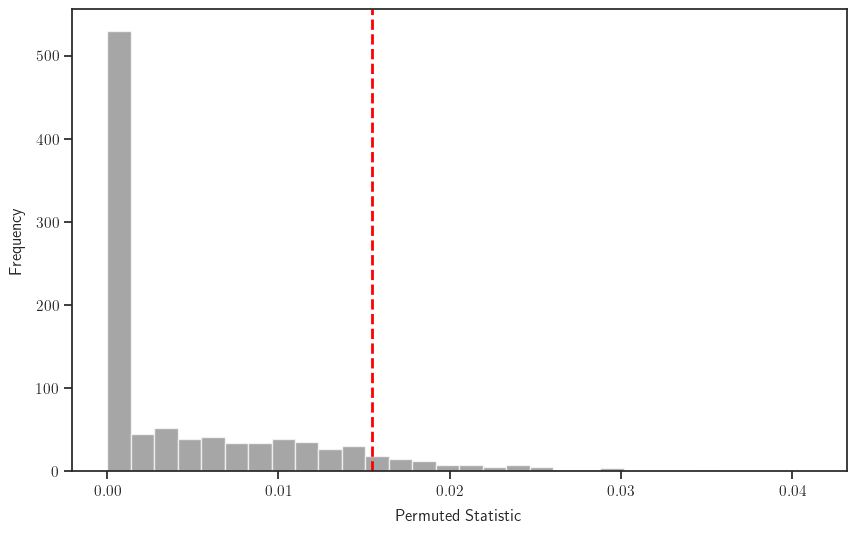

In [53]:
source_cell_type = 'L5 ET'
target_cell_type = 'L5 SST'

source_tf_ids = df.index[(df['cell_type'] == source_cell_type) & (df['region'] == 'core')].astype(np.int32).values
target_tf_ids = df.index[(df['cell_type'] == target_cell_type) & (df['region'] == 'core')].astype(np.int32).values
mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
# Mask voltage_scale_node_ids first
selected_indices = indices[mask]
target_indices = selected_indices[:, 0]
source_indices = selected_indices[:, 1]
# Mask voltage_scale_node_ids first
voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
initial_values = model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids
final_values = model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids
# Calculate tuning angle differences
source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)


observed_mi, permuted_mis, p_value = mutual_info_independence_test(
                tuning_angle_diff, final_values, n_permutations=1000
            )

print(f'Observed MSD: {observed_mi:.4f}')
print(f'Empirical p-value: {p_value:.4f}')

plt.figure(figsize=(10, 6))
plt.hist(permuted_mis, bins=30, color='gray', alpha=0.7)
plt.axvline(observed_mi, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Permuted Statistic')
plt.ylabel('Frequency')
plt.show()

# sample_sizes = [50, 100, 500, 1000, 5000]
# results = stability_analysis(initial_values, final_values, source_tuning_angles, target_tuning_angles, bins, sample_sizes)

In [37]:
# from scipy.stats import wilcoxon
# from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd

sorted_cell_types = np.sort(list(set(v1_cell_types)))

results = []
for source_cell_type in sorted_cell_types:
    source_tf_ids = df.index[(df['cell_type'] == source_cell_type) & (df['region'] == 'core')].astype(np.int32).values
    for target_cell_type in sorted_cell_types:
        target_tf_ids = df.index[(df['cell_type'] == target_cell_type) & (df['region'] == 'core')].astype(np.int32).values
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        # Mask voltage_scale_node_ids first
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_values = model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids
        final_values = model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids

        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
        target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)

        if initial_values.size > 500:  # ensure sufficient data points

            observed_mi, p_value = mutual_info_independence_test(
                tuning_angle_diff, final_values, n_permutations=1000
            )
            results.append({
                'source_cell_type': source_cell_type,
                'target_cell_type': target_cell_type,
                'p_value': p_value,
                'observed_mi': observed_mi,
                'n': source_tuning_angles.size
            })
            

results_df = pd.DataFrame(results)
# Extract p-values
pvals = results_df['p_value'].values

# Apply multiple comparison correction (e.g., Benjamini-Hochberg FDR)
from statsmodels.stats.multitest import multipletests
pvals_corrected = multipletests(pvals, alpha=0.05, method='fdr_bh')[1]

# Add corrected p-values and significance to the DataFrame
results_df['p_value_corrected'] = pvals_corrected
results_df

source_cell_type target_cell_type  p_value  observed_mi      n  \
0           L1 Htr3a         L2/3 Exc    0.385     0.002579  10007   
1           L1 Htr3a           L4 Exc    1.000     0.000000    725   
2           L1 Htr3a            L5 ET    0.265     0.009755   1773   
3           L1 Htr3a            L5 IT    0.037     0.037975   1295   
4           L1 Htr3a           L6 Exc    0.000     0.121280    668   
..               ...              ...      ...          ...    ...   
179           L6 SST         L2/3 Exc    0.195     0.016841   1310   
180           L6 SST           L4 Exc    0.171     0.028328    680   
181           L6 SST            L5 IT    1.000     0.000000   1395   
182           L6 SST           L6 Exc    0.145     0.007929   8953   
183           L6 VIP           L6 Exc    0.237     0.023447    566   

     p_value_corrected  
0             0.547786  
1             1.000000  
2             0.439279  
3             0.113467  
4             0.000000  
..                 ...  
179           0.362535  
180           0.338323  
181           1.000000  
182           0.305273  
183           0.405481  

[184 rows x 6 columns]

In [31]:
# # Identify significant pairs
significant_pairs = results_df[results_df['p_value_corrected'] < 0.05]

# Show significant results clearly
print(significant_pairs) #.head(50))

    source_cell_type target_cell_type  p_value  observed_mi      n  \
4           L1 Htr3a           L6 Exc      0.0     0.121280    668   
5           L2/3 Exc         L1 Htr3a      0.0     0.095283   1983   
7           L2/3 Exc          L2/3 PV      0.0     0.016105  20441   
8           L2/3 Exc         L2/3 SST      0.0     0.015037  15475   
9           L2/3 Exc         L2/3 VIP      0.0     0.023538  10454   
..               ...              ...      ...          ...    ...   
170           L6 Exc            L6 PV      0.0     0.012342  19567   
175            L6 PV            L5 IT      0.0     0.027999   2204   
177            L6 PV           L6 Exc      0.0     0.079845  43420   
178            L6 PV            L6 PV      0.0     0.039962   1543   
180           L6 SST           L4 Exc      0.0     0.028328    680   

     p_value_corrected  
4                  0.0  
5                  0.0  
7                  0.0  
8                  0.0  
9                  0.0  
..       

In [38]:
results_df.sort_values('observed_mi')

source_cell_type target_cell_type  p_value  observed_mi       n  \
25           L2/3 PV         L2/3 VIP      1.0     0.000000    1181   
26           L2/3 PV           L4 Exc      1.0     0.000000    6128   
113            L5 IT          L2/3 PV      1.0     0.000000    1389   
29           L2/3 PV            L5 ET      1.0     0.000000    4729   
106            L5 ET           L4 SST      1.0     0.000000     705   
..               ...              ...      ...          ...     ...   
169           L6 Exc           L6 Exc      0.0     0.150490  130009   
64            L4 Exc            L5 IT      0.0     0.152208   35519   
108            L5 ET            L5 IT      0.0     0.171317    5670   
68            L4 Exc           L6 Exc      0.0     0.306092   44807   
111            L5 ET           L6 Exc      0.0     0.427554    4096   

     p_value_corrected  
25                 1.0  
26                 1.0  
113                1.0  
29                 1.0  
106                1.0  
..                 ...  
169                0.0  
64                 0.0  
108                0.0  
68                 0.0  
111                0.0  

[184 rows x 6 columns]

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


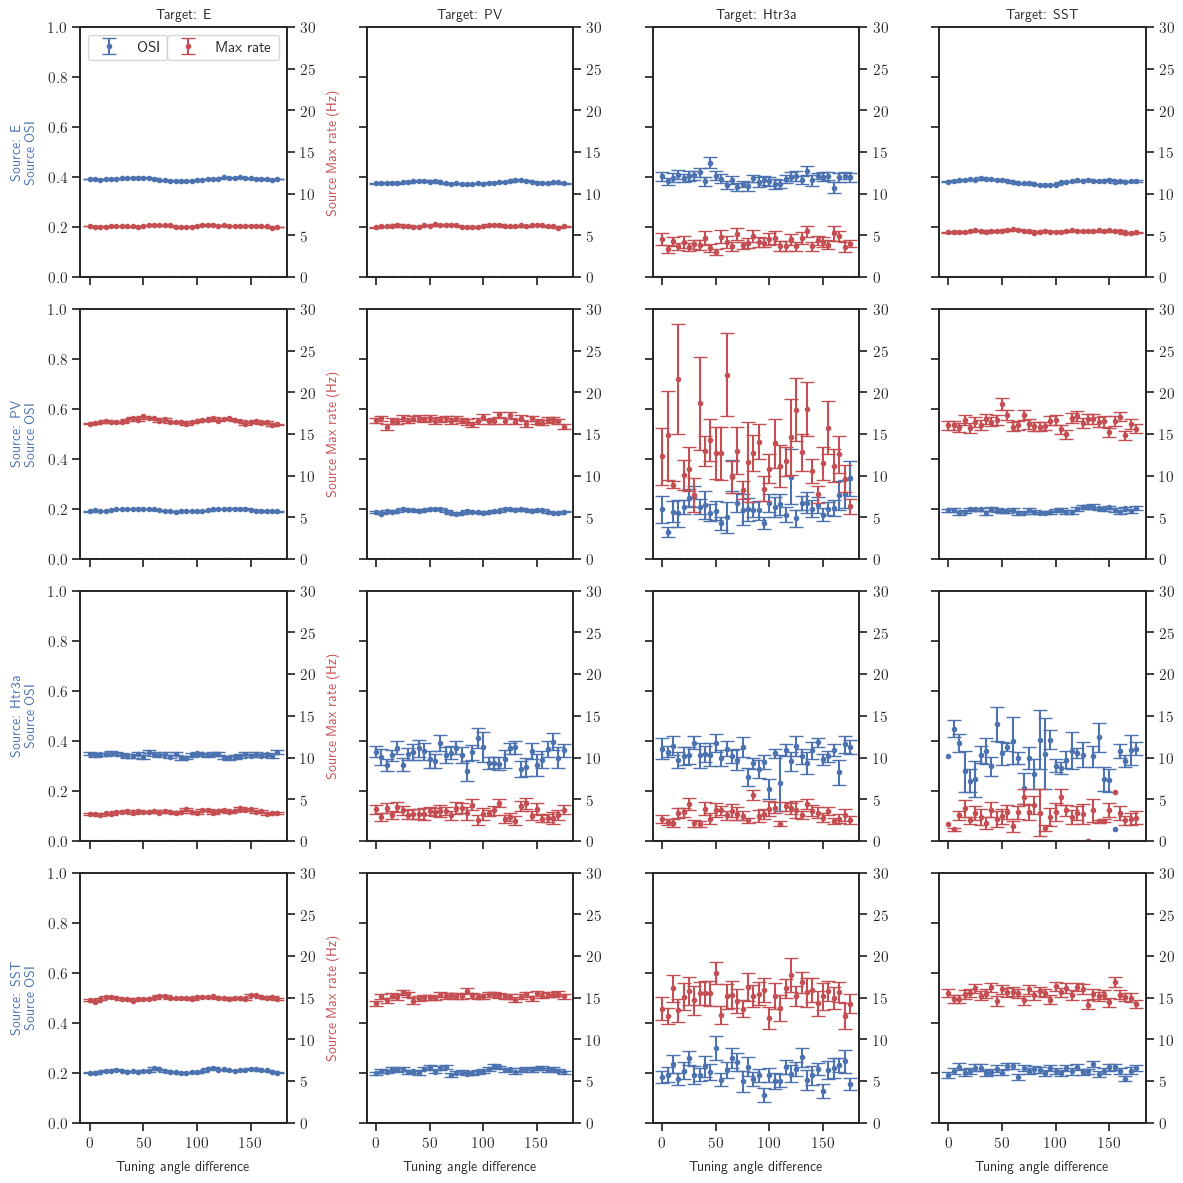

In [ ]:
target_cell_types = ['E', 'PV', 'Htr3a', 'SST'] #['L2/3 Exc', 'L4 Exc', 'L5 Exc', 'L6 Exc']
source_cell_types = ['E', 'PV', 'Htr3a', 'SST']
num_subplots = len(source_cell_types)
        
fig, axs = plt.subplots(len(source_cell_types), 4, figsize=(12, 3*len(source_cell_types)), sharex=True, sharey='row')
axs = axs.flatten()
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    source_tf_ids = df.index[(df['cell_type'].str.contains(source_cell_type)) & (df['region'] == 'core')].astype(np.int32).values
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = df.index[(df['cell_type'].str.contains(target_cell_type)) & (df['region'] == 'core')].astype(np.int32).values
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        source_osi = df.loc[source_indices, 'OSI'].values
        source_max_fr = df.loc[source_indices, 'max_mean_rate(Hz)'].values
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids
        final_value_masked = model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
        target_tuning_angles = df.loc[target_indices, 'preferred_angle'].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)

        # take bins of 1 degree and average the weight values in the corresponding bin
        bins = np.arange(0, 181, 5)
        bin_indices = np.digitize(tuning_angle_diff, bins)
        bin_initial_values = np.zeros(len(bins) - 1)
        bin_initial_errors = np.zeros(len(bins) - 1)  # Array to store the standard error of the mean for each bin
        bin_final_values = np.zeros(len(bins) - 1)
        bin_final_errors = np.zeros(len(bins) - 1)  # Array to store the standard error of the mean for each bin
        for i in range(1, len(bins)):
            max_fr_values_in_bin = source_max_fr[bin_indices == i]
            if max_fr_values_in_bin.size > 0:
                bin_initial_values[i-1] = np.mean(max_fr_values_in_bin)
                std_dev_initial = np.std(max_fr_values_in_bin, ddof=1)
                bin_initial_errors[i-1] = std_dev_initial / np.sqrt(max_fr_values_in_bin.size)
            
            osi_values_in_bin = source_osi[bin_indices == i]
            if osi_values_in_bin.size > 0:
                bin_final_values[i-1] = np.mean(osi_values_in_bin)
                std_dev_final = np.std(osi_values_in_bin, ddof=1)
                bin_final_errors[i-1] = std_dev_final / np.sqrt(osi_values_in_bin.size)

        # plot the average weight values with error bars
        axs[plot_index].errorbar(bins[:-1], bin_final_values, yerr=bin_final_errors, fmt='.', color='b', capsize=5, label='OSI')
        # Create a second y-axis for initial_values
        ax2 = axs[plot_index].twinx()
        ax2.errorbar(bins[:-1], bin_initial_values, yerr=bin_initial_errors, fmt='.', color='r', capsize=5, label=f'Max rate')
        axs[plot_index].axhline(y=0, color='black', linestyle='--')
        axs[plot_index].set_ylim(0, 1)
        ax2.set_ylim(0, 30)
        if row == 0:
            axs[plot_index].set_title(f'Target: {target_cell_type}', fontsize=10)
        if col == 0:
            axs[plot_index].set_ylabel(f'Source: {source_cell_type} \n Source OSI', fontsize=10, color='b') #, rotation=0, labelpad=40)
            ax2.set_ylabel(f'Source Max rate (Hz)', fontsize=10, color='r')
        if row == len(source_cell_types) - 1:
            axs[plot_index].set_xlabel(r'Tuning angle difference', fontsize=10)
        if row == 0 and col == 0:
            axs[plot_index].legend(loc='upper left')
            ax2.legend(loc='upper right')
        plot_index += 1

# fig.suptitle(f'Src Area: {source_area}, Tgt Area: {target_area}')
plt.tight_layout()
plt.show()